# Domain Based Feature Experimentation

This notebook demonstrates the experimentation of using domain-based features from URLs for training SVM and KNearestNeighbours models for classifying malicious URLs

In [126]:
import pandas as pd
import numpy as np
import re
import whois

BASE_DATASET_LOC = '/Users/chrismclearnon/Developer/QUB-CSC3032-FYP/src/data/domain/domain_base_featureset.csv'
FULL_DATASET_LOC = '/Users/chrismclearnon/Developer/QUB-CSC3032-FYP/src/data/domain/domain_full_featureset.csv'

X_TRAIN_DATAFRAME_LOC = '/Users/chrismclearnon/Developer/QUB-CSC3032-FYP/src/data/domain/X_train_dataframe.csv'
X_TEST_DATAFRAME_LOC = '/Users/chrismclearnon/Developer/QUB-CSC3032-FYP/src/data/domain/X_test_dataframe.csv'
X_TRAIN_CSR_LOC = '/Users/chrismclearnon/Developer/QUB-CSC3032-FYP/src/data/domain/x_train.npz'
X_TEST_CSR_LOC = '/Users/chrismclearnon/Developer/QUB-CSC3032-FYP/src/data/domain/x_test.npz'

Y_TRAIN_LOC = '/Users/chrismclearnon/Developer/QUB-CSC3032-FYP/src/data/domain/y_train.csv'
Y_TEST_LOC = '/Users/chrismclearnon/Developer/QUB-CSC3032-FYP/src/data/domain/y_test.csv'

BASE_SVC_LOC = '/Users/chrismclearnon/Developer/QUB-CSC3032-FYP/src/ml-demo-app/api/ml/models/base_svc_model.json'
BAYESIAN_SVC_LOC = '/Users/chrismclearnon/Developer/QUB-CSC3032-FYP/src/ml-demo-app/api/ml/models/bayesian_svc_model.json'
KNN_MODEL_LOC = '/Users/chrismclearnon/Developer/QUB-CSC3032-FYP/src/ml-demo-app/api/ml/models/bayesian_knn_model.json'

CATEGORY_ENC_LOC = '/Users/chrismclearnon/Developer/QUB-CSC3032-FYP/src/ml-demo-app/api/ml/featureprocessing/transformers/cat_enc.json'
SCALER_LOC = '/Users/chrismclearnon/Developer/QUB-CSC3032-FYP/src/ml-demo-app/api/ml/featureprocessing/transformers/scaler.json'
DATE_ENC_LOC = '/Users/chrismclearnon/Developer/QUB-CSC3032-FYP/src/ml-demo-app/api/ml/featureprocessing/transformers/date_enc.json'

In [43]:
base_df = pd.read_csv('/Users/chrismclearnon/Developer/QUB-CSC3032-FYP/src/data/dataset.csv')
print(base_df)

                                                     URL  URLType
0      http://mylust.com/videos/215137/my-raunchy-loo...        0
1      http://mic.com/articles/101766/one-perfect-twe...        0
2      http://stackexchange.com/newsletters/newslette...        0
3      http://bisaneema.org/%e0%a4%ad%e0%a4%be%e0%a4%...        1
4      http://skyrock.com/videos/eDJwODRhNzoxMw==-bug...        0
...                                                  ...      ...
46939  http://themeforest.net/item/artistas-modern-po...        0
46940  http://torcache.net/torrent/2EE5318B3923B273EF...        0
46941  http://grasslandhotel.com.vn/index.php/compone...        1
46942  http://conservativetribune.com/barack-obama-ju...        0
46943  http://sberbank.ru/moscow/ru/person/investment...        0

[46944 rows x 2 columns]


In [14]:
import datetime
from socket import *

def host_ft_extract(url):
    if not url:
        return
    
    feature_list = []
    url_dt = {}
    url_regex = '(?:http.*://)?(?P<host>[^:/ ]+).*'
    url_search = re.search(url_regex, url)
    hostname = url_search.group('host')

    try:
        domain = whois.whois(hostname)
    except whois.parser.PywhoisError:
        url_dt.update({
            "RegistryDate": pd.NaT,
            "ExpirationDate": pd.NaT,
            "HostCountry": None,
            "DomainAge": 0,
        })
        
        feature_list.append(url_dt)
        df = pd.DataFrame(feature_list)
        return df
    except timeout:
        url_dt.update({
            "RegistryDate": pd.NaT,
            "ExpirationDate": pd.NaT,
            "HostCountry": None,
            "DomainAge": 0,
        })
        
        feature_list.append(url_dt)
        df = pd.DataFrame(feature_list)
        
        return df
    except gaierror:
        url_dt.update({
            "RegistryDate": pd.NaT,
            "ExpirationDate": pd.NaT,
            "HostCountry": None,
            "DomainAge": 0,
        })
        
        feature_list.append(url_dt)
        df = pd.DataFrame(feature_list)
        
        return df
    except ConnectionResetError:
        url_dt.update({
            "RegistryDate": pd.NaT,
            "ExpirationDate": pd.NaT,
            "HostCountry": None,
            "DomainAge": 0,
        })
        
        feature_list.append(url_dt)
        df = pd.DataFrame(feature_list)
        
        return df
    except ConnectionRefusedError:
        url_dt.update({
            "RegistryDate": pd.NaT,
            "ExpirationDate": pd.NaT,
            "HostCountry": None,
            "DomainAge": 0,
        })
        
        feature_list.append(url_dt)
        df = pd.DataFrame(feature_list)
        
        return df
        
        
    reg_date = domain.creation_date
    if isinstance(reg_date, list):
        url_dt.update({"RegistryDate": reg_date[0]})
    elif (reg_date is None) or (reg_date == ""):
        url_dt.update({"RegistryDate": pd.NaT})
    else:
        try:
            url_dt.update({"RegistryDate": pd.to_datetime(reg_date)})
        except ValueError:
            url_dt.update({"RegistryDate": pd.NaT})

    exp_date = domain.expiration_date
    if isinstance(exp_date, list):
        url_dt.update({"ExpirationDate": exp_date[0]})
    elif (exp_date is None) or (exp_date == ""):
        url_dt.update({"ExpirationDate": pd.NaT})
    else:
        try:
            url_dt.update({"ExpirationDate": pd.to_datetime(exp_date)})
        except ValueError:
            url_dt.update({"ExpirationDate": pd.NaT})

    country = domain.country
    url_dt.update({"HostCountry": country})

    if pd.isnull(url_dt["RegistryDate"]):
        domain_age = 0
        url_dt.update({"DomainAge": domain_age})
    else:
        domain_age = datetime.datetime.now() - url_dt["RegistryDate"]
        age_in_days = domain_age.days
        url_dt.update({"DomainAge": age_in_days})

    feature_list.append(url_dt)
    df = pd.DataFrame(feature_list)
    
    return df

## Experimental Dataset

For this experiment, a smaller sample of malicious and benign URLs were chosen than in the Lexical Based Feature Experimentation, due to the feature engineering in this experiment taking significantly longer to process.

A sample dataset of 2000 URLs were chosen:
- 1000 benign URLs
- 1000 malicious URLs

In [56]:
benign_df = base_df[base_df.URLType.eq(0)]
benign_df = benign_df[:1000]
benign_df.reset_index()

malicious_df = base_df[base_df.URLType.eq(1)]
malicious_df = malicious_df[:1000]
malicious_df.reset_index()

frames = [benign_df, malicious_df]
domain_df = pd.concat(frames)
domain_df = domain_df.sample(frac=1).reset_index(drop=True)
display(domain_df)

domain_df["URLType"].value_counts()
domain_df.to_csv('/Users/chrismclearnon/Developer/QUB-CSC3032-FYP/src/data/domain/domain_urls.csv', index=False)

,URL,URLType
0,http://hotlinegsm.com/products/mobile-and-tabl...,1
1,http://emgn.com/tv/watch-he-wanted-a-job-at-sn...,0
2,http://distractify.com/post/related/id/55477f7...,0
3,http://olx.in/hi/m/item/laptop-80-gb-ide-hard-...,0
4,http://kenh14.vn/musik/hai-con-gai-cam-ly-lan-...,0
...,...,...
1995,http://www.js182.com/app/member/SportOption.ph...,1
1996,http://3cf.ru/2015/07/21/drygie-mvp-mirovoi-li...,1
1997,http://grasslandhotel.com.vn/index.php/tours/h...,1
1998,http://stackoverflow.com/questions/30062864/wh...,0


## Feature Extraction

Here, the features defined in the host_extract() function above are extracted from each URL in the 2000 sample set. 

Once they all have been processed, then they are saved to a CSV file for base dataset persistence.

In [57]:
dataframe_list = []
for idx, row in domain_df.iterrows():
    print(row['URL'])
    feature_df = host_ft_extract(row['URL'])
    feature_df['URLType'] = row["URLType"]
    dataframe_list.append(feature_df)
    print(feature_df)
    
extracted_df = pd.concat(dataframe_list, ignore_index=True)
extracted_df.reset_index()
print(extracted_df)
extracted_df.to_csv(BASE_DATASET_LOC, index=False)

http://hotlinegsm.com/products/mobile-and-tablet/sony-ericsson-xperia-neo-v-detail
         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2020-02-16 21:07:51 2025-02-16 21:07:51          AE         43        1
http://emgn.com/tv/watch-he-wanted-a-job-at-snapchat-so-he-sent-them-his-my-story-instead-of-a-resume/
         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2004-06-20 18:57:38 2020-06-20 18:57:38          US       5762        0
http://distractify.com/post/related/id/55477f774a0c4b436e941a79/skip/20/limit/10/back/0
         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2013-01-29 09:58:25 2021-01-29 09:58:25          US       2618        0
http://olx.in/hi/m/item/laptop-80-gb-ide-hard-disk-are-available-IDUV945.html?code=bd4a7dc7d3
         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2006-02-22 11:21:13 2021-02-22 11:21:13          NL       5151        0
http://kenh14.vn/musik/hai-con-gai-cam-l

  RegistryDate ExpirationDate HostCountry  DomainAge  URLType
0          NaT            NaT        None          0        1
http://adinamed.com/news/index.php?page=10&catid=0&myord=uptime&myshownums=&showtj=&showdate=&author=&key=
         RegistryDate      ExpirationDate           HostCountry  DomainAge  \
0 2016-02-20 19:31:47 2020-02-20 19:31:47  REDACTED FOR PRIVACY       1500   

   URLType  
0        1  
http://9779.info/%E6%88%91%E7%9A%84%E5%AE%B6%E5%9B%AD%E6%8A%98%E7%BA%B8%E7%B2%98%E8%B4%B4%E7%94%BB/
         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2010-06-22 06:38:59 2023-06-22 06:38:59          CN       3570        1
http://motthegioi.vn/ly-dich/tu-xem-duong-chi-tay-doan-biet-van-menh-tuong-lai-cua-minh-170879.html
  RegistryDate ExpirationDate HostCountry  DomainAge  URLType
0          NaT            NaT        None          0        0
http://industrialtrainingzirakpur.com/asp-dotnet-training-in-zirakpur.html
  RegistryDate ExpirationDate HostCount

         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2010-06-22 06:38:59 2023-06-22 06:38:59          CN       3570        1
http://3cf.ru/2015/07/20/smi-soobshili-o-planah-ssha-yjestochit-dostyp-kompanii-iz-rossii-k-zaimam/
  RegistryDate ExpirationDate HostCountry  DomainAge  URLType
0          NaT            NaT        None          0        1
http://momoshop.com.tw/category/LgrpCategory.jsp?l_code=2111600000&mdiv=1000900000-bt_5_023_11&ctype=B&mdiv=1000900000-bt_5_023_11&ctype=B
  RegistryDate ExpirationDate HostCountry  DomainAge  URLType
0   2004-10-18     2022-10-27        None       5643        0
http://bisaneema.org/wp-content/plugins/easy-media-gallery/includes/js/mootools/easymedia.js?ver=3.9.6
         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2016-06-27 04:48:43 2020-06-27 04:48:43          IN       1373        1
http://bdnews24.com/lifestyle/2015/05/02/extra-two-minutes-walking-can-add-years-to-your-life
         RegistryDat

         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2010-06-22 06:38:59 2023-06-22 06:38:59          CN       3570        1
http://thenextweb.com/apps/2011/07/24/the-complete-list-of-top-instagram-apps/instawar/gtm.js
         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2008-08-02 19:06:27 2020-08-02 19:06:27          PA       4258        0
http://mic.com/articles/110832/jeb-bush-says-he-s-not-like-his-brother-don-t-believe-him
         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 1993-09-30 04:00:00 2025-09-29 04:00:00          US       9679        0
http://www.ilovespeedbumps.com/wp-content/themes/ifeature/core/css/foundation.css
         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2011-11-28 12:25:06 2020-11-28 12:25:06          ZA       3046        1
http://wangqiao365.com/e/wap/show.php?classid=2&id=12&style=0&cpage=0&cid=2&bclassid=0
         RegistryDate      ExpirationDate           Host

         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2012-03-06 20:59:19 2021-03-06 20:59:19          CN       2946        1
http://shop-pro.jp/func/%e7%84%a1%e6%96%99-%e3%82%a2%e3%82%a4%e3%82%b3%e3%83%b3%e3%83%bb%e7%b4%a0%e6%9d%90/
  RegistryDate ExpirationDate HostCountry  DomainAge  URLType
0          NaT            NaT        None          0        0
http://www.waihuift.com/img/aHR0cDovL3FxLmNpMTIzLmNvbS9waG90b3MvMjAxMS8wNi8xNy8xMzA4MjkyNjkxMTM2My5qcGc=.jpg
         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2019-12-04 05:23:05 2020-12-04 05:23:05          CN        118        1
http://www.824555.com/cl/js/jquery-ui-1.8.21.custom.min.js?v=ver17.32
         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2014-07-05 18:43:20 2021-07-05 18:43:20          US       2095        1
http://ecnavi.jp/redirect/?url=http://click.j-a-net.jp/161196/545434/UI%user_id%IT58305FR34
  RegistryDate ExpirationDate HostCountry  DomainAge 

  RegistryDate ExpirationDate HostCountry  DomainAge  URLType
0          NaT            NaT        None          0        0
http://9779.info/%E5%A2%99%E5%A3%81%E8%B4%B4%E7%94%BB%E6%95%88%E6%9E%9C%E5%A4%A7%E5%9B%BE/
         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2010-06-22 06:38:59 2023-06-22 06:38:59          CN       3570        1
http://sourceforge.net/directory/communications/add_facet_filter?facet=os&constraint=Other+Operating+Systems+%3A%3A+WinNT
         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 1999-08-08 04:48:02 2020-08-08 04:47:54          US       7541        0
http://seesaawiki.jp/pathofexile/d/%b9%b9%a4%ca%a4%eb%20Forsaken%20Masters%20%a4%ce%be%f0%ca%f3
  RegistryDate ExpirationDate HostCountry  DomainAge  URLType
0          NaT            NaT        None          0        0
http://9779.info/%E4%BC%9A%E5%8A%A8%E7%9A%84%E6%B0%B4%E6%9E%9C%E7%AE%80%E7%AC%94%E7%94%BB/
         RegistryDate      ExpirationDate HostCountry  D

  RegistryDate ExpirationDate HostCountry  DomainAge  URLType
0          NaT            NaT        None          0        0
http://stackexchange.com/newsletters/newsletter?site=productivity.stackexchange.com
         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2009-06-12 13:55:30 2020-06-12 13:55:30          US       3945        0
http://www.jin0044.com/cl/tpl/jin2015/ver1/css/jin2015.css?v=ver14.32
         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2014-12-31 06:05:20 2021-12-31 06:05:20          US       1917        1
http://9779.info/%E5%89%AA%E8%B4%B4%E7%94%BB%E5%88%9B%E6%84%8F/
         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2010-06-22 06:38:59 2023-06-22 06:38:59          CN       3570        1
http://www.yejs.cn/Article/UploadFiles/201202/20120210093947814.jpg
         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2006-11-10 16:09:39 2020-11-10 16:09:39        None       4890        

         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2014-12-31 06:05:20 2021-12-31 06:05:20          US       1917        1
http://wxztjz.com/e/public/onclick?enews=donews&classid=65&id=110
         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2017-08-11 18:52:19 2020-08-11 18:52:19          CN        962        1
http://metro.co.uk/2012/12/17/games-release-schedule-new-releases-on-xbox-ps3-wii-and-more-350901/
  RegistryDate ExpirationDate HostCountry  DomainAge  URLType
0          NaT     2028-06-17        None          0        0
http://www.mt6669.com/cl/tpl/montecarlo/ver1/css/montecarlo.css?v=ver16.32
         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2015-04-04 11:44:50 2022-04-04 11:44:50          US       1823        1
http://grasslandhotel.com.vn/index.php/component/djcatalog2/items/fbtrack.js
  RegistryDate ExpirationDate HostCountry  DomainAge  URLType
0          NaT            NaT        None          0 

         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2005-04-28 00:32:00 2021-04-28 00:32:00          US       5451        0
http://www.newsvity.com/wp-includes/js/jquery/jquery.js?ver=1.11.2
  RegistryDate ExpirationDate HostCountry  DomainAge  URLType
0          NaT            NaT        None          0        1
http://clien.net/cs2/bbs/register.php?url=%2Fcs2%2Fbbs%2Fboard.php%3Fbo_table%3Dhongbo
         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2001-10-26 06:29:51 2020-10-26 06:29:51          KR       6731        0
http://distractify.com/post/related/id/54414fa94a0c4bc10219be1b/skip/20/limit/10/back/0
         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2013-01-29 09:58:25 2021-01-29 09:58:25          US       2618        0
http://twitter.com/home?status=%E3%83%8C%E3%81%91%E3%82%8B%EF%BC%81%E3%80%90%E3%82%A2%E3%83%8B%E3%83%A1%E3%80%91+http%3A%2F%2Fero-video.net%2Ft%2F9wpLTeudUsCftQxQ+%E9%9D%92%E8%91%89%E9%B3%B4

         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 1996-02-11 05:00:00 2022-02-12 05:00:00          KR       8815        0
http://techcrunch.com/2014/06/25/hands-on-with-googles-incredibly-clever-cardboard-virtual-reality-headset/
         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2005-06-10 22:56:20 2021-06-10 22:56:20          US       5407        0
http://www.pubyun.com/blog/other/dell-r720-%e7%9a%84%e6%b5%8b%e8%af%95/
         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2012-03-06 20:59:19 2021-03-06 20:59:19          CN       2946        1
http://fc2.com/careers/en/index.html?utm_source=fc2com_en_pc&utm_medium=left_menu_bnr&utm_campaign=v1_en
         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 1999-05-20 03:06:00 2028-05-20 03:06:36          CA       7621        0
http://thenextweb.com/apple/2015/03/20/apple-invites-good-morning-america-into-its-secret-apple-watch-fitness-lab/
        

         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2010-06-22 06:38:59 2023-06-22 06:38:59          CN       3570        1
http://3cf.ru/2015/07/20/analitiki-alfa-banka-predskazali-medlennyi-podem-ekonomiki-so-dna/
  RegistryDate ExpirationDate HostCountry  DomainAge  URLType
0          NaT            NaT        None          0        1
http://maybank2u.com.my/mbb_info/m2u/public/promoChannel.do?cntTypeId=1&channelId=PRO-Promotions&programId=PRO02-Cards:AmericanExpress&chCatId=/mbb/Personal/PRO-Promotions
  RegistryDate ExpirationDate HostCountry  DomainAge  URLType
0          NaT            NaT        None          0        0
http://teespring.com/it/balanceiskey?utm_campaign=balanceiskey&utm_medium=oembed&utm_source=wordpress
         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2011-02-09 20:53:37 2021-02-09 20:53:37          US       3337        0
http://katproxy.com/fifty-shades-of-grey-2015-uncut-hc-hdrip-x264-ac3-titan-t10313268.html

         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2012-05-10 00:27:37 2020-05-10 00:27:37          JP       2882        0
http://xvideo-jp.com/archives/tag/%e3%82%a2%e3%82%a4%e3%83%89%e3%83%ab%e3%83%bb%e8%8a%b8%e8%83%bd%e4%ba%ba
         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2012-05-10 00:27:37 2020-05-10 00:27:37          JP       2882        0
http://9779.info/%E5%BA%9F%E6%97%A7%E6%9D%90%E6%96%99%E5%89%AA%E8%B4%B4%E7%94%BB/
         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2010-06-22 06:38:59 2023-06-22 06:38:59          CN       3570        1
http://ap.org/Content/Press-Release/2012/AP-Images-to-exclusively-distribute-NBA-star-Tyson-Chandlers-personal-photo-catalog
         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 1991-07-25 04:00:00 2028-07-24 04:00:00          US      10477        0
http://censor.net.ua/jokes/all/page/1/hero/0/category/118/interval/5/author/0/sortby/date
  Re

         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2003-08-29 10:57:54 2023-08-29 10:57:54          CN       6059        1
http://www.824555.com/cl/tpl/template/style/element/font-awesome.css?v=ver17.32
         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2014-07-05 18:43:20 2021-07-05 18:43:20          US       2095        1
http://allegro.pl/show_item.php?item=5337363633&sh_dwh_token=d0b6dd74a8394345128e20d296cb1c5e
         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 1999-10-27 13:00:00 2020-10-26 14:00:00        None       7461        0
http://thechive.com/2015/05/13/move-over-andrew-jackson-there-might-be-a-new-face-on-the-20-bill-6-photos/
         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2008-07-12 21:44:45 2021-02-23 04:59:59          US       4279        0
http://www.js182.com/app/member/SportOption.php?uid=guest&langx=gb
         RegistryDate      ExpirationDate HostCountry  Domai

         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2004-11-19 05:50:20 2021-11-19 05:50:20          PA       5611        0
http://wangqiao365.com/e/wap/show.php?classid=1&id=14&style=0&cpage=0&cid=1&bclassid=0
         RegistryDate      ExpirationDate           HostCountry  DomainAge  \
0 2019-04-10 02:25:01 2020-04-10 02:25:01  REDACTED FOR PRIVACY        356   

   URLType  
0        1  
http://web.de/magazine/politik/bund-asylverfahren-2000-stellen-beschleunigen-30627004
  RegistryDate ExpirationDate HostCountry  DomainAge  URLType
0          NaT            NaT        None          0        0
http://aljazeera.net/Home/GetPage/f6451603-4dff-4ca1-9c10-122741d17432/a64dbeb5-85f7-4a72-84a2-334164b9b414
         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 1996-08-30 04:00:00 2024-08-29 04:00:00          US       8614        0
http://twitter.com/home?status=%E3%83%8C%E3%81%91%E3%82%8B%EF%BC%81%E3%80%90%E3%82%A2%E3%83%8B%E3%83%A1%E3%80%91+htt

         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 1996-02-11 05:00:00 2022-02-12 05:00:00          KR       8815        0
http://9779.info/%E8%8A%B1%E6%9C%B5%E6%AF%9B%E7%BA%BF%E8%B4%B4%E7%94%BB/
         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2010-06-22 06:38:59 2023-06-22 06:38:59          CN       3570        1
http://www.thereefrestaurant.com/one-drop-saturdays-reef-victoria/
         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2000-03-08 21:45:43 2021-03-08 21:45:43          CA       7327        1
http://style.org.hc360.com/css/detail/mysite/siteconfig/pro_control.css
         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2003-08-29 10:57:54 2023-08-29 10:57:54          CN       6059        1
http://tunein.com/radio/Radio-Shemroon-Persian-s197608/15480783/ca-pub-1542925551861702/Station
         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 1996-05-01 04:00:00 2021

         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 1995-07-16 04:00:00 2021-07-15 04:00:00          US       9025        0
http://thechive.com/2015/05/13/if-your-girlfriend-is-a-gamer-this-is-how-you-propose-6-photos/
         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2008-07-12 21:44:45 2021-02-23 04:59:59          US       4279        0
http://kenh14.vn/2-tek/ban-jailbreak-cho-ios-613-615-chip-a5-chinh-thuc-ra-mat-20131230045123139.chn
  RegistryDate ExpirationDate HostCountry  DomainAge  URLType
0          NaT            NaT        None          0        0
http://9779.info/%E5%84%BF%E7%AB%A5%E7%BA%B8%E5%B7%BE%E8%B4%B4%E7%94%BB/
         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2010-06-22 06:38:59 2023-06-22 06:38:59          CN       3570        1
http://1.gravatar.com/avatar/f5291c12845b6f4b7b9610dfcdfa11d5?s=56&d=http%3A%2F%2F1.gravatar.com%2Favatar%2Fad516503a11cd5ca435acc9bb6523536%3Fs%3D56&r=G
         

         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2014-03-31 08:10:16 2023-03-31 08:10:16          US       2192        1
http://www.ilovespeedbumps.com/vacuum-cleaner-opinions-reading-the-proper-people/
         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2011-11-28 12:25:06 2020-11-28 12:25:06          ZA       3046        1
http://industrialtrainingzirakpur.com/web-designing-training-in-zirakpur.html
  RegistryDate ExpirationDate HostCountry  DomainAge  URLType
0          NaT            NaT        None          0        1
http://9779.info/%E4%B9%8C%E9%B8%A6%E5%96%9D%E6%B0%B4%E6%A0%91%E5%8F%B6%E7%94%BB/
         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2010-06-22 06:38:59 2023-06-22 06:38:59          CN       3570        1
http://olx.in/hi/stateofdelhi/q-%7Bq%7D/?utm_source=google&utm_medium=search&utm_campaign=search_organic
         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2006-02-2

         RegistryDate ExpirationDate HostCountry  DomainAge  URLType
0 2008-09-16 13:28:35     2020-09-19        None       4214        0
http://correios.com.br/para-voce/correios-de-a-a-z/fac-franqueamento-autorizado-de-cartas
  RegistryDate ExpirationDate HostCountry  DomainAge  URLType
0          NaT            NaT        None          0        0
http://interpark.com/displaycorner/FreeMarket.do?_method=itemAreaList&area1=%EB%B6%80%EC%82%B0%EA%B4%91%EC%97%AD%EC%8B%9C&area2=%EC%82%AC%ED%95%98%EA%B5%AC&area3=%EA%B0%90%EC%B2%9C2%EB%8F%99
         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 1996-02-11 05:00:00 2022-02-12 05:00:00          KR       8815        0
http://189.cn/dqmh/ssoLink.do?method=skip&platNo=10014&toStUrl=http://fj.189.cn/service2/actions/Package.action?fluxAccept=&OFFER_ID=902936243
         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2004-05-04 02:14:07 2028-05-04 02:14:07        None       5810        0
http://correios.co

  RegistryDate ExpirationDate HostCountry  DomainAge  URLType
0          NaT            NaT        None          0        1
http://www.zxyey.net/upLoadFiles/eWebEditor/201304/20130418211217978.jpg
         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2016-09-29 18:35:32 2020-09-29 18:35:32          US       1278        1
http://www.jin0044.com/ipl/app/help.php?GameType=5601&lang=zh-cn&HALLID=3820004&State=0
         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2014-12-31 06:05:20 2021-12-31 06:05:20          US       1917        1
http://www.stokesdemocrats.com/wp-content/plugins/really-simple-captcha/gentium/stats/bofa.com/sign-in
         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2008-04-20 10:08:00 2021-04-20 10:08:00          US       4363        1
http://a1.att.hudong.com/54/23/01000000000000119092391688754_02_250_250.jpg
         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2001-05-17 03:04

         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2007-04-02 12:48:32 2021-04-02 12:48:32          CY       4747        0
http://emgn.com/entertainment/13-trampolining-tips-to-spring-you-to-the-top-of-your-game/
         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2004-06-20 18:57:38 2020-06-20 18:57:38          US       5762        0
http://thenextweb.com/creativity/2015/05/04/norwegian-artist-blends-spectacular-animal-portraits-with-their-natural-landscapes/
         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2008-08-02 19:06:27 2020-08-02 19:06:27          PA       4258        0
http://www.facebook.com/sharer.php?u=http://www.greeteasy.com/i-am-lucky-to-have-a-teacher-like-you/
         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2003-09-11 17:06:56 2020-09-11 17:06:56          IN       6045        1
http://9779.info/%E7%81%AB%E6%9F%B4%E5%81%9A%E7%9A%84%E6%8B%BC%E8%B4%B4%E7%94%BB/
       

         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2004-06-20 18:57:38 2020-06-20 18:57:38          US       5762        0
http://serverfault.com/questions/157173/how-to-make-batch-file-automatically-stop-on-error
         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2009-03-15 03:13:53 2021-03-15 03:13:53          US       4034        0
http://steamcommunity.com/gid/103582791430075519/announcements/detail/2074185821667238799
         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2006-05-28 02:08:53 2021-05-28 02:08:53          US       5056        0
http://www.vilagnomad.com/wp-content/plugins/cforms146/js/cforms.js
         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2008-03-13 11:09:23 2021-03-13 11:09:23          US       4401        1
http://fotostrana.ru/app/totem?ref=blink555308831f57dz&from=play.feed.passButton&fromType=1
         RegistryDate      ExpirationDate HostCountry  DomainAge  U

         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2020-03-05 20:19:59 2021-03-05 20:19:59          CN         25        1
http://hotlinegsm.com/products/mobile-and-tablet/nokia-lumia-900-detail
         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2020-02-16 21:07:51 2025-02-16 21:07:51          AE         43        1
http://9779.info/%E5%84%BF%E7%AB%A5%E5%A2%99%E4%B8%8A%E8%A3%85%E9%A5%B0%E8%B4%B4%E7%94%BB/
         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2010-06-22 06:38:59 2023-06-22 06:38:59          CN       3570        1
http://9779.info/%E8%B1%86%E5%AD%90%E9%BB%8F%E8%B4%B4%E7%94%BB/
         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2010-06-22 06:38:59 2023-06-22 06:38:59          CN       3570        1
http://9779.info/%E8%B1%86%E5%AD%90%E7%B2%98%E8%B4%B4%E7%94%BB%E5%8C%85%E5%8C%85/
         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2010-06-22 06:38:59 202

         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2007-09-28 11:09:56 2021-09-28 11:09:56          CN       4568        1
http://kienthuc.net.vn/hoi-dap-ve-tuyen-sinh/phuong-an-thi-moi-co-lam-giam-ty-le-do-tot-nghiep-thpt-463742.html
  RegistryDate ExpirationDate HostCountry  DomainAge  URLType
0          NaT            NaT        None          0        0
http://haishundl.com/a/qinpengqipaiguanfangxiazai/20130929/119.html
         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2018-06-25 05:49:58 2020-06-25 05:49:58          CN        645        1
http://www.wu8188.com/cl/?module=System&method=LiveTop&args=livehall
         RegistryDate      ExpirationDate           HostCountry  DomainAge  \
0 2017-05-20 18:31:08 2020-05-20 18:31:08  REDACTED FOR PRIVACY       1045   

   URLType  
0        1  
http://www.longfengxie.com/img/aHR0cDovL3Jlcy5kYWRpa2lkLm5ldC9FZGl0b3IvMjAxMC8xMS8yMDEwMTExNjE1MzAyOTYzNy5qcGc=.jpg
         RegistryDate      Expir

         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2000-03-08 21:45:43 2021-03-08 21:45:43          CA       7327        1
http://tobogo.net/cdsb/board.php?board=storyani&bm=view&no=80&category=&auth=&page=1&search=&keyword=&recom=
         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2017-08-06 18:26:17 2020-08-06 18:26:17          US        967        0
http://sourceforge.net/directory/audio-video/add_facet_filter?facet=natlanguage&constraint=Polish
         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 1999-08-08 04:48:02 2020-08-08 04:47:54          US       7541        0
http://abc.go.com/shows/secrets-and-lies/episode-guide/season-01/10-season-finale-the-lie
         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 1998-01-09 05:00:00 2021-01-08 05:00:00          US       8117        0
http://indianexpress.com/article/good-news/watch-video-aditi-rao-dia-mirza-lushin-dubey-come-in-support-of-and-

         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2011-11-21 15:01:28 2024-11-21 15:01:28          US       3053        0
http://9779.info/%E5%8D%A1%E9%80%9A%E7%B1%B3%E8%B4%B4%E7%94%BB%E5%9B%BE%E7%89%87/
         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2010-06-22 06:38:59 2023-06-22 06:38:59          CN       3570        1
http://putlocker.is/watch-geordie-shore-tvshow-season-6-episode-3-online-free-putlocker.html
  RegistryDate ExpirationDate HostCountry  DomainAge  URLType
0   2019-12-10     2020-12-10        None        112        0
http://slashdot.org/index2.pl?view=search&fhfilter=medicine&startdate=201519w&index=1
         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 1997-10-05 04:00:00 2020-10-04 04:00:00          US       8213        0
http://babal.net/downloads_details/1238/%D8%A7%D8%B9%D9%84%D8%A7%D9%86-%D9%81%D9%8A%D9%84%D9%85-%D9%88%D8%A7%D8%AD%D8%AF-%D8%B5%D8%B9%D9%8A%D8%AF%D9%89
         RegistryDa

         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2011-04-29 11:29:16 2020-04-29 11:29:16          US       3259        0
http://extratorrent.cc/torrent_download/4189696/Official+PlayStation+Magazine+UK+-+We+Have+Played+it+first+Verdict+%282015-06%29+%28True+PDF%29.torrent
         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2010-12-03 12:08:35 2023-12-03 12:08:35          BS       3406        0
http://www.xpj5988.com/skin/css/cn.css;jsessionid=A77C20A90C6790855CB2882AD06183ED
         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2014-11-03 12:17:56 2021-11-03 12:17:56          US       1975        1
http://wangqiao365.com/e/wap/show.php?classid=2&id=12&style=0&cpage=0&cid=2&bclassid=0
         RegistryDate      ExpirationDate           HostCountry  DomainAge  \
0 2019-04-10 02:25:01 2020-04-10 02:25:01  REDACTED FOR PRIVACY        356   

   URLType  
0        1  
http://bjpgqsc.com/cp/class/?0.html&page=3&showtj=&

         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2010-06-22 06:38:59 2023-06-22 06:38:59          CN       3570        1
http://wanwang.aliyun.com/domain/searchresult/?domain=bigtruckstopseek.cn
         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2007-09-28 11:09:56 2021-09-28 11:09:56          CN       4568        1
http://9779.info/%E6%9D%90%E6%96%99%E8%A1%A8%E7%8E%B0%E6%8B%BC%E8%B4%B4%E7%94%BB/
         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2010-06-22 06:38:59 2023-06-22 06:38:59          CN       3570        1
http://thenextweb.com/facebook/2015/04/27/make-a-donation-on-facebook-to-nepal-earthquake-survivors/gtm.js
         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2008-08-02 19:06:27 2020-08-02 19:06:27          PA       4258        0
http://olx.pl/i2/nieruchomosci/garaze-parkingi/zamiana/nieruchomosci/garaze-parkingi/zamiana
         RegistryDate      ExpirationDate HostCountr

         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2003-10-12 22:23:19 2021-10-12 22:23:19          US       6014        1
http://grasslandhotel.com.vn/index.php/tours/mysontours/items/fbtrack.js
  RegistryDate ExpirationDate HostCountry  DomainAge  URLType
0          NaT            NaT        None          0        1
http://3cf.ru/2015/07/21/hokkei-nhl-podtverdila-chto-zaiavki-na-vstyplenie-v-ligy-podali-tolko-kvebek-i-las-vegas/
  RegistryDate ExpirationDate HostCountry  DomainAge  URLType
0          NaT            NaT        None          0        1
http://babal.net/books/view/1264/%D8%A7%D9%84%D8%A3%D8%B0%D9%83%D8%A7%D8%B1-%D9%84%D9%80-%D8%A7%D9%84%D8%A5%D9%85%D8%A7%D9%85-%D8%A7%D9%84%D9%86%D9%88%D9%88%D9%89
         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2013-03-19 20:03:25 2021-03-19 20:03:25          EG       2568        0
http://chinesevie.com/index.php?option=com_content&view=article&id=105&Itemid=130&lang=en
         Regist

         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2010-06-22 06:38:59 2023-06-22 06:38:59          CN       3570        1
http://chinacxyy.com/piccodejs-000.asp?lm2=191&x=3&y=2&w=90&h=63&open=1&n=10&tj=0
         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2014-04-02 02:15:54 2020-04-02 02:15:54          CN       2190        1
http://metro.co.uk/2015/05/12/mental-health-awareness-week-a-few-things-to-keep-in-mind-5193193/
  RegistryDate ExpirationDate HostCountry  DomainAge  URLType
0          NaT     2028-06-17        None          0        0
http://bdnews24.com/science/2015/04/02/rodent-romance-male-mice-use-love-songs-to-woo-their-women
         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2004-08-28 04:23:26 2022-08-28 04:23:26          US       5694        0
http://wikiwiki.jp/sample/?%A5%C7%A5%B6%A5%A4%A5%F3%A5%C6%A5%F3%A5%D7%A5%EC%A1%BC%A5%C8%2Fdefault_blue_z
  RegistryDate ExpirationDate HostCountry  DomainA

         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2011-04-29 11:29:16 2020-04-29 11:29:16          US       3259        0
http://9779.info/%E5%A2%99%E5%A3%81%E8%B4%B4%E7%94%BB%E6%95%88%E6%9E%9C%E5%A4%A7%E5%9B%BE/
         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2010-06-22 06:38:59 2023-06-22 06:38:59          CN       3570        1
http://haishundl.com/a/qinpengqipaiguanfangxiazai/20131001/130.html
         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2018-06-25 05:49:58 2020-06-25 05:49:58          CN        645        1
http://9779.info/%E5%B9%BC%E5%84%BF%E5%9B%AD%E7%B2%98%E8%B4%B4%E7%94%BB%E8%AF%B4%E8%AF%BE%E7%A8%BF/
         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2010-06-22 06:38:59 2023-06-22 06:38:59          CN       3570        1
http://otomoto.pl/oferta/ford-mondeo-ford-mondeo-mk3-hatchback-benzyna-gaz-2006-srebrny-polska-ID6y4RyD.html
         RegistryDate      ExpirationDat

         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 1994-06-02 04:00:00 2021-06-01 04:00:00          US       9434        0
http://aljazeera.net/home/allprograms?programtype=eff1ba72-2465-4c24-ab83-25deeca2257c
         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 1996-08-30 04:00:00 2024-08-29 04:00:00        None       8614        0
http://9779.info/%E6%9F%93%E7%BA%B8%E4%BD%9C%E5%93%81%E5%89%AA%E8%B4%B4%E7%94%BB/
         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2010-06-22 06:38:59 2023-06-22 06:38:59          CN       3570        1
http://sourceforge.net/directory/communications/add_facet_filter?facet=os&constraint=Other+Operating+Systems+%3A%3A+Microsoft+Windows+Server+2003
         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 1999-08-08 04:48:02 2020-08-08 04:47:54          US       7541        0
http://haishundl.com/a/qinpengqipaiguanfangxiazai/20131006/164.html
         RegistryDate    

         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 1999-12-02 15:08:09 2020-12-02 15:08:09          US       7425        0
http://seekingalpha.com/news/2518826-futures-on-the-rise-as-rates-continue-to-pull-back
         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2004-09-03 20:40:52 2020-09-03 20:40:52        None       5687        0
http://9779.info/%E8%93%9D%E8%89%B2%E6%B5%B7%E6%B4%8B%E5%89%AA%E8%B4%B4%E7%94%BB/
         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2010-06-22 06:38:59 2023-06-22 06:38:59          CN       3570        1
http://9779.info/%E5%89%AA%E8%B4%B4%E7%94%BB%E5%9B%BE%E7%89%87%E5%A4%A7/
         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2010-06-22 06:38:59 2023-06-22 06:38:59          CN       3570        1
http://9779.info/%E4%BA%8C%E5%B9%B4%E7%BA%A7%E7%9A%84%E8%B1%86%E5%AD%90%E7%B2%98%E8%B4%B4%E7%94%BB/
         RegistryDate      ExpirationDate HostCountry  DomainAge 

         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2010-03-11 20:09:19 2021-03-11 19:09:19        None       3672        1
http://tobogo.net/cdsb/board.php?board=comic&bm=view&no=223&category=&auth=&page=1&search=&keyword=&recom=
         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2017-08-06 18:26:17 2020-08-06 18:26:17          US        967        0
http://9779.info/%E9%B1%BC%E7%9A%84%E6%AF%9B%E7%BA%BF%E7%B2%98%E8%B4%B4%E7%94%BB/
         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2010-06-22 06:38:59 2023-06-22 06:38:59          CN       3570        1
http://nguyentandung.org/quy-dinh-chi-tiet-mot-so-noi-dung-ve-quy-hoach-xay-dung.html
  RegistryDate ExpirationDate HostCountry  DomainAge  URLType
0          NaT            NaT        None          0        0
http://tu.webps.cn/tb/img/4/TB1amOIHXXXXXcEXXXXXXXXXXXX_%21%210-item_pic.jpg
         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2007

         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2006-02-22 11:21:13 2021-02-22 11:21:13          NL       5151        0
http://3cf.ru/2015/03/04/iz-vzorvannoi-shahty-v-donecke-pytautsia-spasti-70-shahterov/
  RegistryDate ExpirationDate HostCountry  DomainAge  URLType
0          NaT            NaT        None          0        1
http://cltmusic.com/wp-content/uploads/formidable/css/formidablepro.css
         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2008-10-15 15:37:53 2020-10-15 15:37:53          US       4185        1
http://thenextweb.com/insider/2014/10/21/giphy-launches-new-api-offer-searchable-animated-sticker-gifs-inside-favorite-apps/
         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2008-08-02 19:06:27 2020-08-02 19:06:27          PA       4258        0
http://maybank2u.com.my/mbb_info/m2u/public/personalDetail04.do?channelId=CRD-Cards&cntTypeId=0&cntKey=CRD01.32&programId=CRD01-CreditCards&chCatId=

         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2014-11-03 12:17:56 2021-11-03 12:17:56          US       1975        1
http://style.org.hc360.com/css/detail/mysite/siteconfig/pro_control.css
         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2003-08-29 10:57:54 2023-08-29 10:57:54          CN       6059        1
http://mic.com/articles/101766/one-perfect-tweet-calls-out-the-hypocrisy-of-how-the-media-talks-about-black-violence
         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 1993-09-30 04:00:00 2025-09-29 04:00:00          US       9679        0
http://jmdongnan.com/daxibeimuban/template/jianfei/images/css.css
         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2016-08-08 18:53:41 2020-08-08 18:53:41          CN       1330        1
http://www.wu8188.com/cl/?module=System&method=LiveTop&args=livehall
         RegistryDate      ExpirationDate           HostCountry  DomainAge  \
0 2017

         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2010-06-22 06:38:59 2023-06-22 06:38:59          CN       3570        1
http://9779.info/%E5%B0%8F%E5%AD%A6%E7%94%9F%E5%95%86%E6%A0%87%E5%89%AA%E8%B4%B4%E7%94%BB/
         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2010-06-22 06:38:59 2023-06-22 06:38:59          CN       3570        1
http://torcache.net/torrent/D4E7D05E1558476F3A341EE68C3F8188112E5B19.torrent?title=[kickass.to]exodus.dei.e.re.2014.italian.ac3.dual.bluray.1080p.x264.team
         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2011-04-29 11:29:16 2020-04-29 11:29:16          US       3259        0
http://thenextweb.com/entrepreneur/2015/04/27/how-to-be-successful-at-a-tech-trade-show/gtm.js
         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2008-08-02 19:06:27 2020-08-02 19:06:27          PA       4258        0
http://sourceforge.net/directory/communications/add_facet_filter?f

         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2014-02-25 00:44:07 2024-02-25 00:44:07          US       2226        0
http://9779.info/%E6%A0%91%E5%8F%B6%E7%AE%80%E5%8D%95%E7%B2%98%E8%B4%B4%E7%94%BB/
         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2010-06-22 06:38:59 2023-06-22 06:38:59          CN       3570        1
http://depositphotos.com/login.html?url=%2F33474795%2Fstock-illustration-vector-abstract-3d-paper-infographics.html
         RegistryDate      ExpirationDate           HostCountry  DomainAge  \
0 2009-02-07 19:41:59 2028-02-07 19:41:59  REDACTED FOR PRIVACY       4069   

   URLType  
0        0  
http://olx.ro/i2/anunturi-agricole/utilaje-agricole/piese-si-alte-utilaje-agricole/
  RegistryDate ExpirationDate HostCountry  DomainAge  URLType
0   2006-03-22     2020-08-22        None       5123        0
http://9779.info/%E4%BA%B2%E5%AD%90%E7%B2%98%E8%B4%B4%E7%94%BB%E5%9B%BE%E7%89%87%E6%AC%A3%E8%B5%8F/
         Regist

  RegistryDate ExpirationDate HostCountry  DomainAge  URLType
0          NaT            NaT        None          0        0
http://9779.info/%E5%A4%8D%E6%9D%82%E7%9A%84%E7%A7%8D%E5%AD%90%E6%8B%BC%E8%B4%B4%E7%94%BB/
         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2010-06-22 06:38:59 2023-06-22 06:38:59          CN       3570        1
http://nesn.com/2013/06/draft-pick-kelly-olynyk-will-fit-in-well-with-new-look-celtics-video/
         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 1995-07-16 04:00:00 2021-07-15 04:00:00          US       9025        0
http://icicibank.com/Personal-Banking/onlineservice/online-services/FundsTransfer/rtgs.page
         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 1996-07-16 04:00:00 2021-07-15 04:00:00          IN       8659        0
http://zozo.jp/shop/bshop/?price=proper&p_ssy=2015&p_ssm=5&p_ssd=13&p_sey=2015&p_sem=5&p_sed=13&dstk=2
  RegistryDate ExpirationDate HostCountry  DomainAge

  RegistryDate ExpirationDate HostCountry  DomainAge  URLType
0          NaT            NaT        None          0        0
http://9779.info/%E5%BF%AB%E4%B9%90%E6%9A%91%E5%81%87%E7%9A%84%E5%89%AA%E8%B4%B4%E7%94%BB/
         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2010-06-22 06:38:59 2023-06-22 06:38:59          CN       3570        1
https://quizlet.com/sign-up?redir=https%3A%2F%2Fquizlet.com%2F6396803%2Fmetric-prefixes-flash-cards%2F
         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2004-07-15 13:39:24 2020-07-15 13:39:24          US       5738        0
http://otomoto.pl/osobowe/skoda/octavia/i-1996-2011/-/hatchback/cjHrqwbiJHVRXsm58b3On2Xj356Nc2LOoVjQJGN3qOz.b7
         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2004-06-14 17:25:27 2020-06-14 17:25:27        None       5768        0
http://pjhku.com/plugin.php?id=levsign&m=2&fh=6848d1f0&hook=1&mobile=no
         RegistryDate      ExpirationDate           Hos

         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2006-02-22 11:21:13 2021-02-22 11:21:13          NL       5151        0
http://www.58tpw.com/Template/Default_2009_08/images/map_134.jpg
         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2014-09-30 18:33:47 2020-09-30 18:33:47          CN       2008        1
http://mashable.com/category/international-space-station/2015/03/18/astronauts-aurora-iss
         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2005-07-19 14:50:34 2026-07-19 14:50:34          US       5369        0
http://katproxy.com/avg-internet-security-2015-15-0-5576-serial-techtools-t9892064.html
  RegistryDate ExpirationDate HostCountry  DomainAge  URLType
0          NaT            NaT        None          0        0
http://katproxy.com/marc-dorcel-manon-secretaire-debutante-xxx-webrip-new-2015-t10593425.html
  RegistryDate ExpirationDate HostCountry  DomainAge  URLType
0          NaT            NaT    

         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2013-03-19 20:03:25 2021-03-19 20:03:25          EG       2568        0
http://ap.org/Content/AP-In-The-News/2014/AP-veteran-leading-Pennsylvania-New-Jersey-news
         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 1991-07-25 04:00:00 2028-07-24 04:00:00          US      10477        0
http://9779.info/%E5%84%BF%E7%AB%A5%E4%BC%98%E7%A7%80%E5%9B%BE%E7%94%BB%E4%BD%9C%E5%93%81/
         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2010-06-22 06:38:59 2023-06-22 06:38:59          CN       3570        1
http://3cf.ru/2015/03/04/britancy-otkazyvautsia-ot-raboty-s-okladom-v-40-tysiach-fyntov-v-god/
  RegistryDate ExpirationDate HostCountry  DomainAge  URLType
0          NaT            NaT        None          0        1
http://tobogo.net/cdsb/board.php?board=storymovie&bm=view&no=8374&category=&auth=&page=1&search=&keyword=&recom=
         RegistryDate      ExpirationDate H

         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 1997-03-29 05:00:00 2028-03-30 04:00:00          US       8403        1
http://mic.com/articles/115266/it-s-official-hillary-clinton-is-running-for-president
         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 1993-09-30 04:00:00 2025-09-29 04:00:00          US       9679        0
http://9779.info/%E5%B9%BC%E5%84%BF%E5%9B%AD%E7%B2%98%E8%B4%B4%E7%94%BB%E8%AF%B4%E8%AF%BE%E7%A8%BF/
         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2010-06-22 06:38:59 2023-06-22 06:38:59          CN       3570        1
http://9779.info/%E5%84%BF%E7%AB%A5%E5%BD%A9%E7%BA%B8%E7%B2%98%E8%B4%B4%E7%94%BB/
         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2010-06-22 06:38:59 2023-06-22 06:38:59          CN       3570        1
http://searchengineland.com/3-ways-adwords-scripts-will-make-your-holidays-merrier-178128
         RegistryDate      ExpirationDate HostCoun

         RegistryDate      ExpirationDate           HostCountry  DomainAge  \
0 2009-02-07 19:41:59 2028-02-07 19:41:59  REDACTED FOR PRIVACY       4069   

   URLType  
0        0  
http://mtsx.com.cn/UploadFiles/2011-08/admin/%C2%B5%C3%8B%C2%BE%C2%B0%C3%93%C3%A8%C2%A1%C2%A2%C2%B5%C3%8B%C2%BE%C2%B0%C3%8E%C3%84%C3%8D%C2%AC%C3%90%C3%85%C3%8F%C2%A2%C2%B0%C3%82%C3%88%C3%BC%C3%90%C2%A1%C3%91%C2%A1%C3%8A%C3%96.JPG
         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2012-08-20 17:36:12 2021-08-20 17:36:12        None       2779        1
http://extratorrent.cc/torrent_download/4189434/NFB.Canada.At.War.09of13.The.Norman.Summer.XviD.AC3+.avi.torrent
         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2010-12-03 12:08:35 2023-12-03 12:08:35          BS       3406        0
http://thenextweb.com/me/2012/05/30/arabic-overtakes-english-as-the-most-popular-language-on-facebook-in-the-middle-east/gtm.start
         RegistryDate      ExpirationDate HostC

         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 1991-07-25 04:00:00 2028-07-24 04:00:00          US      10477        0
http://13801993263.com/wp-content/themes/glossy-stylo/style.css?ver=4.2.2
         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2015-06-17 07:55:56 2025-06-17 07:55:56          BS       1749        1
http://9779.info/%E6%B0%91%E6%97%8F%E5%B8%83%E8%89%BA%E8%B4%B4%E7%94%BB/
         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2010-06-22 06:38:59 2023-06-22 06:38:59          CN       3570        1
http://schertzauto.com/wp-content/plugins/revslider/rs-plugin/css/settings.css?rev=4.6.0&ver=4.2.2
         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2003-10-12 22:23:19 2021-10-12 22:23:19          US       6014        1
http://putlocker.is/watch-seal-team-eight-behind-enemy-lines-online-free-putlocker.html
  RegistryDate ExpirationDate HostCountry  DomainAge  URLType
0   2019-12-

         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2000-01-21 16:28:17 2021-01-21 16:28:17          US       7375        0
http://fanpage.gr/stories/%ce%ad%cf%83%cf%89%cf%83%ce%b5-%ce%bc%ce%b9%ce%b1-%ce%b6%cf%89%ce%ae-%ce%ba%ce%b1%ce%b9-%ce%bc%ce%b5%cf%84%ce%ac-%cf%80%ce%b7%ce%b3%ce%b1%ce%af%ce%bd%ce%b5%ce%b9-%ce%bd%ce%b1-%ce%b1%cf%80/
  RegistryDate ExpirationDate HostCountry  DomainAge  URLType
0          NaT            NaT        None          0        0
http://9779.info/%E5%88%9D%E4%B8%AD%E7%94%BB%E7%9A%84%E5%AE%89%E5%85%A8%E6%89%8B%E6%8A%84%E6%8A%A5/
         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2010-06-22 06:38:59 2023-06-22 06:38:59          CN       3570        1
http://hotlinegsm.com/products/mobile-and-tablet/htc-velocity-4g-vodafone-detail
         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2020-02-16 21:07:51 2025-02-16 21:07:51          AE         43        1
http://sfglobe.com/2015/04/30/baltim

         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2010-06-22 06:38:59 2023-06-22 06:38:59          CN       3570        1
http://9779.info/%E6%88%91%E7%9A%84%E5%91%A8%E6%9C%AB%E5%89%AA%E8%B4%B4%E7%94%BB/
         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2010-06-22 06:38:59 2023-06-22 06:38:59          CN       3570        1
http://www.pubyun.com/wiki/lib/exe/css.php?t=dokuwiki&tseed=f1f16e8c6142fab8553f2b9cfe045961
         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2012-03-06 20:59:19 2021-03-06 20:59:19          CN       2946        1
http://putlocker.is/watch-turn-washingtons-spies-tvshow-season-2-episode-4-online-free-putlocker.html
  RegistryDate ExpirationDate HostCountry  DomainAge  URLType
0   2019-12-10     2020-12-10        None        112        0
http://9779.info/%E5%B9%BC%E5%84%BF%E5%90%B8%E7%AE%A1%E7%B2%98%E8%B4%B4%E7%94%BB/
         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType

         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2010-06-22 06:38:59 2023-06-22 06:38:59          CN       3570        1
http://www.wu8188.com/cl/tpl/five-star/ver1/css/five-star.css?v=ver15.32
         RegistryDate      ExpirationDate           HostCountry  DomainAge  \
0 2017-05-20 18:31:08 2020-05-20 18:31:08  REDACTED FOR PRIVACY       1045   

   URLType  
0        1  
http://9779.info/%E6%A0%91%E5%8F%B6%E7%B2%98%E8%B4%B4%E7%94%BB/
         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2010-06-22 06:38:59 2023-06-22 06:38:59          CN       3570        1
http://depositphotos.com/login.html?url=%2F11956277%2Fstock-illustration-set-of-london-symbols.html
         RegistryDate      ExpirationDate           HostCountry  DomainAge  \
0 2009-02-07 19:41:59 2028-02-07 19:41:59  REDACTED FOR PRIVACY       4069   

   URLType  
0        0  
http://pikabu.ru/tag/%D0%BF%D0%BE%D0%B4%D0%B1%D0%BE%D1%80%D0%BA%D0%B0%20%D1%84%D0%BE%D1%82%D0%BE%D0%B

         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2020-03-05 20:19:59 2021-03-05 20:19:59          CN         25        1
http://www.thenathanbaker.com/thenathanbaker.com/wordpress/wp-content/themes/graphene/style.css?ver=4.0.5
         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2008-03-04 11:48:53 2021-03-04 11:48:53          US       4410        1
http://9779.info/%E7%8E%B0%E4%BB%A3%E6%8B%9B%E8%B4%B4%E7%94%BB%E8%AE%BE%E8%AE%A1/
         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2010-06-22 06:38:59 2023-06-22 06:38:59          CN       3570        1
http://allrecipes.com/Recipes/Everyday-Cooking/Main.aspx?prop24=hn_browsedeeper&evt19=1
         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 1998-07-11 04:00:00 2020-07-10 04:00:00          US       7934        0
http://extratorrent.cc/torrent_download/4191162/%5BMichelleThornExxxposed%5D+Michelle%2C+Carla+Cox+%2805.14.2015%29.torrent
        

         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2010-06-22 06:38:59 2023-06-22 06:38:59          CN       3570        1
http://9779.info/%E4%B8%B0%E6%94%B6%E5%89%AA%E8%B4%B4%E7%94%BB%E5%9B%BE%E7%89%87/
  RegistryDate ExpirationDate HostCountry  DomainAge  URLType
0          NaT            NaT        None          0        1
http://9779.info/%E6%A0%91%E5%8F%B6%E7%B2%98%E8%B4%B4%E7%94%BB/
         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2010-06-22 06:38:59 2023-06-22 06:38:59          CN       3570        1
http://motthegioi.vn/kinh-te/tin-trong-nuoc-va-quoc-te/an-do-se-la-ba-chu-kinh-te-nam-2050-188321.html
  RegistryDate ExpirationDate HostCountry  DomainAge  URLType
0          NaT            NaT        None          0        0
http://thenextweb.com/in/2014/11/13/uber-introduces-paytm-digital-wallet-payments-india-response-new-e-commerce-ruling/feed/gtm.start
         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType

         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2014-11-03 12:17:56 2021-11-03 12:17:56          US       1975        1
http://motthegioi.vn/ho-so-tu-lieu/kiet-suc-vi-no-nan-kien-tung-dong-thap-vai-tu-phuong-183488.html
  RegistryDate ExpirationDate HostCountry  DomainAge  URLType
0          NaT            NaT        None          0        0
http://9779.info/%E6%96%87%E6%98%8E%E5%9C%A8%E6%88%91%E5%AE%B6%E5%89%AA%E8%B4%B4%E7%94%BB/
         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2010-06-22 06:38:59 2023-06-22 06:38:59          CN       3570        1
http://serverfault.com/questions/302479/why-servers-error-log-states-lots-of-file-doesnt-exist-but-files-are-accessibl
  RegistryDate ExpirationDate HostCountry  DomainAge  URLType
0          NaT            NaT        None          0        0
http://www.jin0044.com/cl/tpl/template/style/element/font-awesome.css?v=ver14.32
         RegistryDate      ExpirationDate HostCountry  DomainAge 

         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2010-06-22 06:38:59 2023-06-22 06:38:59          CN       3570        1
http://udn.com/news/story/7340/894388-%E6%B4%AA%E8%98%AD%EF%BC%8F%E8%AE%93%E5%AD%B8%E7%94%9F%E5%B0%8D%E7%94%9F%E5%91%BD%E6%9C%89%E6%9C%9F%E5%BE%85
         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 1998-09-10 04:00:00 2021-09-09 04:00:00        None       7873        0
http://9779.info/%E5%85%B3%E4%BA%8E%E6%85%88%E7%88%B1%E7%B2%98%E8%B4%B4%E7%94%BB/
         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2010-06-22 06:38:59 2023-06-22 06:38:59          CN       3570        1
http://9779.info/%E6%A0%91%E5%8F%B6%E8%8A%B1%E7%93%A3%E7%9A%84%E7%B2%98%E8%B4%B4%E7%94%BB/
         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2010-06-22 06:38:59 2023-06-22 06:38:59          CN       3570        1
http://style.org.hc360.com/css/detail/mysite/siteconfig/pro_control.css
         Registr

         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2018-06-25 05:49:58 2020-06-25 05:49:58          CN        645        1
http://youkuedu.com/index.php/youku-dynamic/338-2014-08-06-03-49-35
         RegistryDate      ExpirationDate           HostCountry  DomainAge  \
0 2009-10-22 02:06:38 2022-10-22 02:06:38  REDACTED FOR PRIVACY       3813   

   URLType  
0        1  
http://wikimapia.org/32988066/ru/%D0%97%D0%B0%D0%BA%D1%80%D1%8B%D1%82%D0%B0%D1%8F-%D0%B0%D0%B2%D1%82%D0%BE%D0%BC%D0%BE%D0%B1%D0%B8%D0%BB%D1%8C%D0%BD%D0%B0%D1%8F-%D1%81%D1%82%D0%BE%D1%8F%D0%BD%D0%BA%D0%B0
         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2006-01-26 21:09:47 2021-01-26 21:09:47          RU       5177        0
http://elcomercio.pe/politica/elecciones/otra-vez-andres-elecciones-2016-tunel-noticia-1809700?ref=portada_politica&ft=mod_click&e=foto
  RegistryDate ExpirationDate HostCountry  DomainAge  URLType
0          NaT            NaT        None          

         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2019-10-11 18:49:53 2020-10-11 18:49:53        None        171        0
http://9779.info/%E5%89%AA%E8%B4%B4%E7%94%BB%E5%9B%BE%E7%89%87%E5%A4%A7/
         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2010-06-22 06:38:59 2023-06-22 06:38:59          CN       3570        1
http://emgn.com/tv/watch-16-shy-guys-who-will-never-figure-out-where-to-put-their-hands/
         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2004-06-20 18:57:38 2020-06-20 18:57:38          US       5762        0
http://9779.info/%E7%B2%AE%E9%A3%9F%20%E7%B2%98%E8%B4%B4%E7%94%BB/
         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2010-06-22 06:38:59 2023-06-22 06:38:59          CN       3570        1
http://lovettz.com/wooden-interlocking-monogram-wall-decor/monogram-wall-decor-design-pink/
  RegistryDate ExpirationDate HostCountry  DomainAge  URLType
0          NaT           

         RegistryDate      ExpirationDate           HostCountry  DomainAge  \
0 2012-07-10 08:24:05 2021-07-10 08:24:05  REDACTED FOR PRIVACY       2821   

   URLType  
0        1  
http://9779.info/%E6%BC%82%E4%BA%AE%E7%9A%84%E6%92%95%E8%B4%B4%E7%94%BB/
         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2010-06-22 06:38:59 2023-06-22 06:38:59          CN       3570        1
http://emgn.com/entertainment/23-diy-nail-hacks-that-will-make-you-a-home-manicure-pro/
         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2004-06-20 18:57:38 2020-06-20 18:57:38          US       5762        0
http://www.jin0044.com/cl/js/jquery-ui-1.8.21.custom.min.js?v=ver14.32
         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2014-12-31 06:05:20 2021-12-31 06:05:20          US       1917        1
http://distractify.com/post/related/id/554b8d3f4a0c4b0a3d066a71/skip/10/limit/10/back/0
         RegistryDate      ExpirationDate HostCountry

         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2011-04-29 11:29:16 2020-04-29 11:29:16          US       3259        0
http://www.wu8188.com/cl/js/jquery-ui-1.8.21.custom.min.js?v=ver15.32
         RegistryDate      ExpirationDate           HostCountry  DomainAge  \
0 2017-05-20 18:31:08 2020-05-20 18:31:08  REDACTED FOR PRIVACY       1045   

   URLType  
0        1  
http://9779.info/%E5%90%B8%E7%AE%A1%20%E5%89%AA%E8%B4%B4%E7%94%BB/
         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2010-06-22 06:38:59 2023-06-22 06:38:59          CN       3570        1
http://9779.info/%E8%B1%86%E5%AD%90%E7%B2%98%E8%B4%B4%E7%94%BB/
         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2010-06-22 06:38:59 2023-06-22 06:38:59          CN       3570        1
http://abc.go.com/shows/the-bachelorette/video/kaitlyn-bristowe-season-19-bachelor-highlights/VDKA0_4lvcum8n
         RegistryDate      ExpirationDate HostCountry  DomainAg

         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2010-06-22 06:38:59 2023-06-22 06:38:59          CN       3570        1
http://espn.go.com/racing/indycar/story/_/id/12879796/helio-castroneves-walks-away-scary-crash-indy-500-practice
         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 1998-01-09 05:00:00 2021-01-08 05:00:00          US       8117        0
http://9779.info/%E8%A1%8D%E7%BA%B8%E8%B4%B4%E7%94%BB%E5%9B%BE%E7%89%87%E6%AC%A3%E8%B5%8F/
         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2010-06-22 06:38:59 2023-06-22 06:38:59          CN       3570        1
http://www.jin0044.com/cl/?module=System&method=MAdvertis&other=JoinMember
         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2014-12-31 06:05:20 2021-12-31 06:05:20          US       1917        1
http://kakaku.com/daily-goods/clean-wiper-sheet/ranking_7643/pricedown/div-gpt-ad-k/header_text
         RegistryDate      Expira

         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2003-03-25 21:26:58 2021-03-25 20:26:58          US       6215        0
http://schertzauto.com/wp-content/plugins/revslider/rs-plugin/css/settings.css?rev=4.6.0&ver=4.2.2
         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2003-10-12 22:23:19 2021-10-12 22:23:19          US       6014        1
http://9779.info/%E6%9D%90%E6%96%99%E8%A1%A8%E7%8E%B0%E6%8B%BC%E8%B4%B4%E7%94%BB/
         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2010-06-22 06:38:59 2023-06-22 06:38:59          CN       3570        1
http://torcache.net/torrent/51CF5222B8D84784DAA168BCEA95202986139784.torrent?title=[kickass.to]step.up.all.in.2014.720p.bdrip.x264.dual.audio.hindi.english.loki.m2tv
         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2011-04-29 11:29:16 2020-04-29 11:29:16          US       3259        0
http://aljazeera.net/Home/GetPage/f6451603-4dff-4ca1-9c10-122

         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2011-04-29 11:29:16 2020-04-29 11:29:16          US       3259        0
http://www.0068555.com/cl/?module=System&method=LiveTop&args=livehall
         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2014-07-04 07:35:02 2021-07-04 07:35:02          CN       2097        1
http://grasslandhotel.com.vn/index.php/tours/hoiantours/items/fbtrack.js
  RegistryDate ExpirationDate HostCountry  DomainAge  URLType
0          NaT            NaT        None          0        1
http://9779.info/%E6%A0%91%E5%8F%B6%E5%B0%8F%E5%A5%B3%E5%AD%A9%E7%B2%98%E8%B4%B4%E7%94%BB/
         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2010-06-22 06:38:59 2023-06-22 06:38:59          CN       3570        1
http://haishundl.com/a/qinpengqipaiguanfangxiazai/20131009/176.html
         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2018-06-25 05:49:58 2020-06-25 05:49:58          CN   

         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2011-04-14 15:24:51 2022-04-14 15:24:51          US       3274        0
http://nguyentandung.org/nong-lenovo-co-tinh-cai-san-phan-mem-do-tham-tao-co-hoi-cho-hackers-tan-cong.html
  RegistryDate ExpirationDate HostCountry  DomainAge  URLType
0          NaT            NaT        None          0        0
http://torcache.net/torrent/793D77F5434B3C4DB2374FE3205B611355B58A49.torrent?title=[kickass.to]the.blacklist.proper.temporada.2.hdtv.cap.206.espa%C3%B1ol.spanish
         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2011-04-29 11:29:16 2020-04-29 11:29:16          US       3259        0
http://hotlinegsm.com/products/mobile-and-tablet/sony-ericsson-xperia-neo-v-detail
         RegistryDate      ExpirationDate HostCountry  DomainAge  URLType
0 2020-02-16 21:07:51 2025-02-16 21:07:51          AE         43        1
http://www.west263.com/services/domain/aprice_show.asp?d=bigtruckstopseek.cn
   

AttributeError: type object 'DataFrame' has no attribute 'concat'

## Data Pre-processing
In order for the extracted feature sets to be used to train the SVM and KNN models, they have to go through pre-processing so that they are coverted into numerical vector space.

- For the DateTime type features: **RegistryDate & Expiration Date**, they need to be numerically encoded.
- Any missing values within the feature sets need to be processed as well, because machine learning models cannot process missing data directly. For this dataset, that includes:
    - Missing Registry/Expiration date components (year / month / day)
    - Missing Domain Age values due to missing date components previously specified


In [86]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, RobustScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

class DateEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, col_names=[]):
        self.col_names = col_names

    def fit(self, *_):
        return self

    def transform(self, X):
        df_list = []
        for column in self.col_names:
            dt = X[column].dt
            year_series = dt.year
            month_series = dt.month
            day_series = dt.day

            frame = {
                f'{column}_year': year_series,
                f'{column}_month': month_series,
                f'{column}_day': day_series
            }
            dt_df = pd.DataFrame.from_dict(frame)
            dt_df = dt_df.astype(float)
            df_list.append(dt_df)

        df_list.append(X)
        dfs = pd.concat(df_list, axis=1)
        dfs = dfs.drop(self.col_names, axis=1)
        return dfs
    
class DomainAgeImputer(TransformerMixin):
    def fit(self, X, *_):
        return self
    
    def transform(self, X, *_):
        reg_date = pd.to_datetime(X.RegistryDate_year*10000+X.RegistryDate_month*100+X.RegistryDate_day,format='%Y%m%d')
        age_arr = datetime.datetime.now() - reg_date
        X['DomainAge'] = age_arr.dt.days
        return X
        
class MissingValueImputer(TransformerMixin):
    def __init__(self, strategy, missing_values):
        self.missing_values = missing_values
        self.strategy = strategy
        self.imputer = SimpleImputer

    def fit(self, X, *_):
        self.imputer = self.imputer(missing_values=self.missing_values, strategy=self.strategy)
        self.imputer.fit(X)
        return self

    def transform(self, X, *_):
        transformed = self.imputer.transform(X)
        return transformed

In [97]:
import datetime

new_df = pd.read_csv(BASE_DATASET_LOC)
new_df['RegistryDate'] = pd.to_datetime(new_df['RegistryDate'])
new_df['ExpirationDate'] = pd.to_datetime(new_df['ExpirationDate'])
print(f'Base DataFrame columns & types: \n{new_df.dtypes}\n\n')

date_encoder = DateEncoder(col_names=['RegistryDate', 'ExpirationDate'])
date_encoder.fit(new_df)
new_df = date_encoder.transform(new_df)
print(f'Date encoded DataFrame columns & types: \n{new_df.dtypes}')

Base DataFrame columns & types: 
RegistryDate      datetime64[ns]
ExpirationDate    datetime64[ns]
HostCountry               object
DomainAge                  int64
URLType                    int64
dtype: object


Date encoded DataFrame columns & types: 
RegistryDate_year       float64
RegistryDate_month      float64
RegistryDate_day        float64
ExpirationDate_year     float64
ExpirationDate_month    float64
ExpirationDate_day      float64
HostCountry              object
DomainAge                 int64
URLType                   int64
dtype: object


- Now that the RegistryDate & ExpirationDate columns have been transformed by the DateEncoder transformer, the MissingValueImputer and DomainAgeImputer transformers will now impute any missing values from the new year/month/day columns, and then impute any missing DomainAge values

In [102]:
missing_imputer = MissingValueImputer(strategy='most_frequent', missing_values=np.nan)
arr = missing_imputer.fit_transform(new_df)
new_df = pd.DataFrame(data=arr, columns=new_df.columns)

age_imputer = DomainAgeImputer()
new_df = age_imputer.fit_transform(new_df)

new_df.RegistryDate_year = new_df.RegistryDate_year.astype(np.int64)
new_df.RegistryDate_month = new_df.RegistryDate_month.astype(np.int64)
new_df.RegistryDate_day = new_df.RegistryDate_day.astype(np.int64)
new_df.ExpirationDate_year = new_df.ExpirationDate_year.astype(np.int64)
new_df.ExpirationDate_month = new_df.ExpirationDate_month.astype(np.int64)
new_df.ExpirationDate_day = new_df.ExpirationDate_day.astype(np.int64)

display(new_df)

new_df.to_csv(FULL_DATASET_LOC, index=False)

,RegistryDate_year,RegistryDate_month,RegistryDate_day,ExpirationDate_year,ExpirationDate_month,ExpirationDate_day,HostCountry,DomainAge,URLType
0,2020,2,16,2025,2,16,AE,63,1
1,2004,6,20,2020,6,20,US,5782,0
2,2013,1,29,2021,1,29,US,2637,0
3,2006,2,22,2021,2,22,NL,5170,0
4,2010,6,22,2020,6,22,US,3589,0
...,...,...,...,...,...,...,...,...,...
1995,2014,9,26,2020,9,26,CN,2032,1
1996,2010,6,22,2020,6,22,US,3589,1
1997,2010,6,22,2020,6,22,US,3589,1
1998,2003,12,26,2021,2,2,US,5959,0


## Category Encoding

Now the HostCountry feature needs to be encoded - It contains string object values which are not accepted by machine learning models. 

To encode the values of this feature, the CategoryEncoder transformer has been developed, that utilises the OneHotEncoder method from Scikit-Learn:
- Cycles through each value and creates a new binary column for each unique value seen
- Creates a more expressive way of representing each HostCountry value

E.g: The CategoryEncoder would encode a HostCountry series like [US, CN, US, FR, UK] like:\
- [
      [1, 0, 1, 0, 0],
      [0, 1, 0, 0, 0],
      [1, 0, 1, 0, 0],
      [0, 0, 0, 1, 0],
      [0, 0, 0, 0, 1]
  ] 
  
## Feature Scaling

After all of the encoding has been processed, the feature set then needs to have a scaler function applied to it. This is to reduce the risk that one feature takes dominance over any other whenever a classifier is attempting to learn patterns within the dataset.

The DomainFeatureScaler transformer has been developed to apply a scaler function to the dataset. In particular, a MinMaxScaler is used as the scaler function.

In [105]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, RobustScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

class CategoryEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, handle_unknown='ignore', columns=[], has_fit=False, encoder=OneHotEncoder):
        self.handle_unknown = handle_unknown
        self.columns = columns
        self.encoder = encoder
        self.categories = []
        self.has_fit = has_fit

    def fit(self, X, *_):
        if self.has_fit:
            self.encoder = self.encoder(handle_unknown=self.handle_unknown, categories=categories)
            self.encoder.fit(X)
            return self
        else:
            self.encoder = self.encoder(handle_unknown='ignore')
            self.encoder.fit(X)
            self.categories = self.encoder.categories_
            self.has_fit = True
            return self

    def transform(self, X, *_):
        encoded = self.encoder.transform(X)
        return encoded

class DomainFeatureScaler(BaseEstimator, TransformerMixin):
    def __init__(self, scaler=MinMaxScaler, has_fit=False, scaler_loc=""):
        self.scaler = scaler
        self.has_fit = has_fit
        self.scaler_loc = scaler_loc

    def fit(self, X, *_):
        if self.has_fit:
            self.scaler = deserialize(json_to_data(MinMaxScaler(), json_to_data("", self.scaler_loc)))
        else:
            self.scaler = self.scaler()
            self.scaler.fit(X)
            self.has_fit=True
        return self

    def transform(self, X, *_):
        scaled = self.scaler.transform(X)
        return scaled

## Base SVM Classifier Training

A base SVM classifier model will now be trained using the pre-processed datasets to get a base performance level before SVM optimisation is explored.

- The default parameters that Scikit-Learn applies to a default init SVC() is used as the base hyperparameters

In [108]:
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, make_scorer

dataframe = pd.read_csv(FULL_DATASET_LOC)
X, Y = dataframe.drop(['URLType'], axis=1), dataframe['URLType']
X_train, x_test, Y_train, y_test = train_test_split(X, Y, test_size = 0.33, random_state = 42)

X_train.to_csv(X_TRAIN_DATAFRAME_LOC, index=False)
x_test.to_csv(X_TEST_DATAFRAME_LOC, index=False)

encoder = CategoryEncoder(handle_unknown='ignore', columns=['HostCountry'])
t =[('categorial_encoder', encoder, ['HostCountry']),]
scaler = DomainFeatureScaler()
transformer = ColumnTransformer(t, remainder=scaler)
transformer.fit(X_train, Y_train)

X_train = transformer.transform(X_train)
x_test = transformer.transform(x_test)

In [110]:
import scipy.sparse

scipy.sparse.save_npz(X_TRAIN_CSR_LOC, X_train)
scipy.sparse.save_npz(X_TEST_CSR_LOC, x_test)

Y_train.to_csv(Y_TRAIN_LOC, header=None)
y_test.to_csv(Y_TEST_LOC, header=None)

/Users/chrismclearnon/miniconda3/envs/proj-env/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  
/Users/chrismclearnon/miniconda3/envs/proj-env/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  import sys


In [112]:
def tn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 0]
def fp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 1]
def fn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 0]
def tp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 1]

def tnr(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    rate = (tn/(tn+fp))
    return rate

def tpr(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    rate = (tp/(tp+fn))
    return rate

def fnr(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    rate = (fn/(fn+tp))
    return rate

def fpr(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    rate = (fp/(fp+tn))
    return rate

scoring = {'tp': make_scorer(tp),
           'tn': make_scorer(tn),
           'fp': make_scorer(fp),
           'fn': make_scorer(fn),
           'tpr': make_scorer(tpr),
           'tnr': make_scorer(tnr),
           'fpr': make_scorer(fpr),
           'fnr': make_scorer(fnr),
}

In [163]:
base_svc = SVC()
cv = KFold(n_splits=10, shuffle=True, random_state=1)

scores = cross_validate(base_svc, X_train, Y_train, scoring=scoring, cv=cv, n_jobs=-1)

start_time = time.time()
base_svc.fit(X_train, Y_train)
print("--- %s seconds ---" % (time.time() - start_time))

def get_avg_stats(stat):
    total = 0
    for item in stat:
        total += item
    
    avg = (total/stat.size)
    return avg

print("Base SVC() Model Average Performance Metrics\n\nTP: {}\nRate: {}\n\nTN: {}\nRate: {}\n\nFP: {}\nRate: {}\n\nFN: {}\nRate: {}\n".format(
    get_avg_stats(scores["test_tp"]),
    get_avg_stats(scores["test_tpr"]),
    get_avg_stats(scores["test_tn"]),
    get_avg_stats(scores["test_tnr"]),
    get_avg_stats(scores["test_fp"]),
    get_avg_stats(scores["test_fpr"]),
    get_avg_stats(scores["test_fn"]),
    get_avg_stats(scores["test_fnr"]),
))

--- 0.1355600357055664 seconds ---
Base SVC() Model Average Performance Metrics

TP: 47.5
Rate: 0.7238032035740843

TN: 66.1
Rate: 0.9668350342529439

FP: 2.3
Rate: 0.03316496574705599

FN: 18.1
Rate: 0.27619679642591555



In [114]:
import json
import collections
import scipy

def isnamedtuple(obj):
    """Heuristic check if an object is a namedtuple."""
    return isinstance(obj, tuple) \
           and hasattr(obj, "_fields") \
           and hasattr(obj, "_asdict") \
           and callable(obj._asdict)
        
def serialize(data):
    if data is None or isinstance(data, (bool, int, float, str)):
        return data
    if isinstance(data, list):
        return [serialize(val) for val in data]
    if isinstance(data, collections.OrderedDict):
        return {"py/collections.OrderedDict":
                [[serialize(k), serialize(v)] for k, v in data.iteritems()]}
    if isnamedtuple(data):
        return {"py/collections.namedtuple": {
            "type":   type(data).__name__,
            "fields": list(data._fields),
            "values": [serialize(getattr(data, f)) for f in data._fields]}}
    if isinstance(data, dict):
        if all(isinstance(k, str) for k in data):
            return {k: serialize(v) for k, v in data.items()}
        return {"py/dict": [[serialize(k), serialize(v)] for k, v in data.items()]}
    if isinstance(data, tuple):
        return {"py/tuple": [serialize(val) for val in data]}
    if isinstance(data, set):
        return {"py/set": [serialize(val) for val in data]}
    if isinstance(data, np.ndarray):
        return {"py/numpy.ndarray": {
            "values": data.tolist(),
            "dtype":  str(data.dtype)}}
    if isinstance(data, scipy.sparse.csr.csr_matrix):
        data = data.toarray()
        return {"py/scipy.csr_matrix": {
            "values": data.tolist(),
            "dtype":  str(data.dtype)}}
    if isinstance(data, OneHotEncoder):
        return
    raise TypeError("Type %s not data-serializable" % type(data))
    
    
def restore(dct):
    if "py/dict" in dct:
        return dict(dct["py/dict"])
    if "py/tuple" in dct:
        return tuple(dct["py/tuple"])
    if "py/set" in dct:
        return set(dct["py/set"])
    if "py/collections.namedtuple" in dct:
        data = dct["py/collections.namedtuple"]
        return namedtuple(data["type"], data["fields"])(*data["values"])
    if "py/numpy.ndarray" in dct:
        data = dct["py/numpy.ndarray"]
        return np.array(data["values"], dtype=data["dtype"])
    if "py/collections.OrderedDict" in dct:
        return OrderedDict(dct["py/collections.OrderedDict"])
    if "py/scipy.csr_matrix" in dct:
        data = dct["py/scipy.csr_matrix"]
        arr =  np.array(data["values"], dtype=data["dtype"])
        return sparse.csr_matrix(arr)
    if "py/sklearn.preprocessing._encoders.OneHotEncoder" in dct:
        attr = dct["py/sklearn.preprocessing._encoders.OneHotEncoder"]
        return deserialize(SVC(), attr)
    return dct
    
def data_to_json(data, location):
    attr_json = serialize(data)
    with open(location, "w") as write_file:
        json.dump(attr_json, write_file)
    return json.dumps(attr_json, indent=4)

def json_to_data(s, file):
    with open(file, "r") as read_file:
        attr_data = json.load(read_file, object_hook=restore)
        return attr_data

def deserialize(estim, attr):
    for k, v in attr.items():
        setattr(estim, k, v)
    return estim

In [118]:
cat_enc_loc = CATEGORY_ENC_LOC
scaler_loc = SCALER_LOC
date_enc_loc = DATE_ENC_LOC
data_to_json(transformer.transformers_[0][1].__dict__, cat_enc_loc)
data_to_json(date_encoder.__dict__, date_enc_loc)
data_to_json(transformer.transformers_[1][1].__dict__['scaler'].__dict__, scaler_loc)

params = base_svc.__dict__
model_params_loc = BASE_SVC_LOC
data_to_json(params, model_params_loc)

'{\n    "decision_function_shape": "ovr",\n    "break_ties": false,\n    "kernel": "rbf",\n    "degree": 3,\n    "gamma": "scale",\n    "coef0": 0.0,\n    "tol": 0.001,\n    "C": 1.0,\n    "nu": 0.0,\n    "epsilon": 0.0,\n    "shrinking": true,\n    "probability": false,\n    "cache_size": 200,\n    "class_weight": null,\n    "verbose": false,\n    "max_iter": -1,\n    "random_state": null,\n    "_sparse": true,\n    "class_weight_": {\n        "py/numpy.ndarray": {\n            "values": [\n                1.0,\n                1.0\n            ],\n            "dtype": "float64"\n        }\n    },\n    "classes_": {\n        "py/numpy.ndarray": {\n            "values": [\n                0,\n                1\n            ],\n            "dtype": "int64"\n        }\n    },\n    "_gamma": 0.3907455092742481,\n    "support_": {\n        "py/numpy.ndarray": {\n            "values": [\n                15,\n                16,\n                23,\n                25,\n                33,\

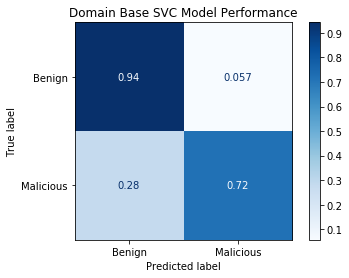

'Base SVC() Accuracy Score: 0.8272727272727273'

In [167]:
import json
import collections
from scipy import sparse
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

base_svc = deserialize(SVC(), json_to_data("", model_params_loc))
y_pred=base_svc.predict(x_test)

from sklearn.metrics import plot_confusion_matrix
disp = plot_confusion_matrix(base_svc, x_test, y_test,
                                 display_labels=['Benign', 'Malicious'],
                                 cmap=plt.cm.Blues,
                                 normalize='true')
disp.ax_.set_title('Domain Base SVC Model Performance')
plt.show()
display(f'Base SVC() Accuracy Score: {accuracy_score(y_test, y_pred, normalize=True)}')

## Bayesian Optimisation

Now that a base SVM classifier performance has been established, the hyperparameters of the SVM model need to be tweaked or altered in some way such that 

In [124]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.model_selection import train_test_split

svc_search = {
    'C': Real(1e-6, 1e+6, prior='log-uniform'),
    'gamma': Real(1e-6, 1e+1, prior='log-uniform'),
    'kernel': Categorical(['poly', 'rbf']),
    'degree': Integer(1,8),
}

searchcv = BayesSearchCV(
    SVC(probability=True),
    search_spaces = svc_search,
    n_iter=10,
    cv=cv,
    verbose=5,
    n_jobs=-1
)

def on_step(optim_result):
    score = searchcv.best_score_
    print(f'Best score: {score}')

    
import time
start_time = time.time()
searchcv.fit(X_train, Y_train, callback=on_step)
print("--- %s seconds ---" % (time.time() - start_time))

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    3.7s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Best score: 0.5104477611940299
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.8s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Best score: 0.7716417910447761
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:   17.1s remaining:   11.4s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   26.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Best score: 0.8888059701492538
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.8s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Best score: 0.8888059701492538
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.9s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Best score: 0.8888059701492538
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.8s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Best score: 0.8888059701492538
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.7s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Best score: 0.8888059701492538
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.6s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.8s finished


Best score: 0.8888059701492538
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.9s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.2s finished


Best score: 0.8888059701492538
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.8s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.0s finished


Best score: 0.8888059701492538
--- 46.2431161403656 seconds ---


TPR: 0.8255813953488372
TNR: 0.9493670886075949
FPR: 0.05063291139240506
FNR: 0.1744186046511628
Optimised SVC() Accuracy Score: 0.8848484848484849
Best params found: {'C': 37168.94513973376, 'degree': 2, 'gamma': 0.5077610523963544, 'kernel': 'rbf'}


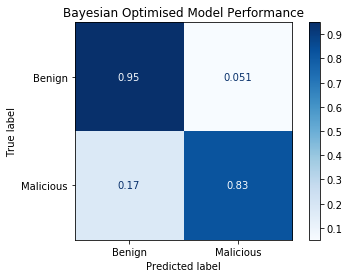

'{\n    "decision_function_shape": "ovr",\n    "break_ties": false,\n    "kernel": "rbf",\n    "degree": 2,\n    "gamma": 0.5077610523963544,\n    "coef0": 0.0,\n    "tol": 0.001,\n    "C": 37168.94513973376,\n    "nu": 0.0,\n    "epsilon": 0.0,\n    "shrinking": true,\n    "probability": true,\n    "cache_size": 200,\n    "class_weight": null,\n    "verbose": false,\n    "max_iter": -1,\n    "random_state": null,\n    "_sparse": true,\n    "class_weight_": {\n        "py/numpy.ndarray": {\n            "values": [\n                1.0,\n                1.0\n            ],\n            "dtype": "float64"\n        }\n    },\n    "classes_": {\n        "py/numpy.ndarray": {\n            "values": [\n                0,\n                1\n            ],\n            "dtype": "int64"\n        }\n    },\n    "_gamma": 0.5077610523963544,\n    "support_": {\n        "py/numpy.ndarray": {\n            "values": [\n                15,\n                16,\n                105,\n                

In [166]:
y_pred = searchcv.predict(x_test)
print(f'TPR: {tpr(y_test, y_pred)}\nTNR: {tnr(y_test, y_pred)}\nFPR: {fpr(y_test, y_pred)}\nFNR: {fnr(y_test, y_pred)}')
print(f'Optimised SVC() Accuracy Score: {accuracy_score(y_test, y_pred)}')
print(f'Best params found: {searchcv.best_params_}')

disp = plot_confusion_matrix(searchcv.best_estimator_, x_test, y_test,
                                 display_labels=['Benign', 'Malicious'],
                                 cmap=plt.cm.Blues,
                                 normalize='true')
disp.ax_.set_title('Bayesian Optimised Model Performance')
plt.show()

data_to_json(searchcv.best_estimator_.__dict__, BAYESIAN_SVC_LOC)

In [159]:
metrics = ['mean_test_score', 'mean_fit_time', 'param_C', 'param_gamma', 'param_kernel', 'param_degree']

print('Optimised SVC() BayesianSearchCV Metrics Results\n\n')
idx = 0
for _ in searchcv.cv_results_['params']:
    print(f'===Iteration {idx+1}===')
    for metric in metrics:
        print(f'- {metric}: {searchcv.cv_results_[metric][idx]}')
    idx+=1
    print('\n\n')

Optimised SVC() BayesianSearchCV Metrics Results


===Iteration 1===
- mean_test_score: 0.5104477611940299
- mean_fit_time: 0.33426485061645506
- param_C: 367.6908636307772
- param_gamma: 2.9746775711588428e-05
- param_kernel: poly
- param_degree: 6



===Iteration 2===
- mean_test_score: 0.7716417910447761
- mean_fit_time: 0.34900803565979005
- param_C: 1.2497710014927421
- param_gamma: 0.0042332936981880126
- param_kernel: rbf
- param_degree: 7



===Iteration 3===
- mean_test_score: 0.8888059701492538
- mean_fit_time: 9.167046117782593
- param_C: 37168.94513973376
- param_gamma: 0.5077610523963544
- param_kernel: rbf
- param_degree: 2



===Iteration 4===
- mean_test_score: 0.5104477611940299
- mean_fit_time: 0.3449851989746094
- param_C: 0.0006710499689918636
- param_gamma: 0.3370933720580881
- param_kernel: poly
- param_degree: 4



===Iteration 5===
- mean_test_score: 0.5104477611940299
- mean_fit_time: 0.4017037868499756
- param_C: 1.5324335299393713e-05
- param_gamma: 0.0534110

Base model AUC: 0.9048379084486311
Optimised model AUC: 0.9422698336767736


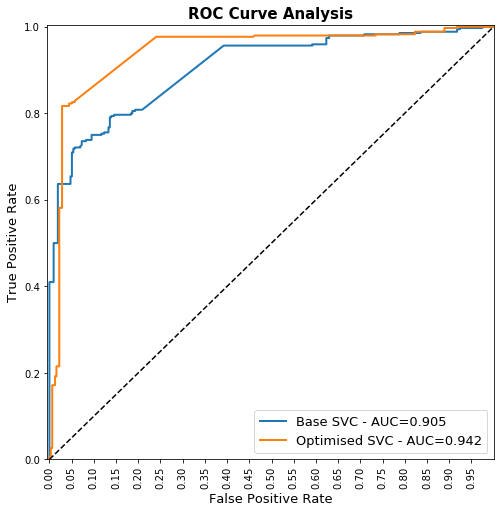

In [158]:
from sklearn.metrics import roc_curve, auc

y_scores_base = base_svc.decision_function(x_test)
y_scores_opt = searchcv.decision_function(x_test)

fpr_base, tpr_base, auc_thresholds_base = roc_curve(y_test, y_scores_base)
fpr_bayesian, tpr_bayesian, auc_thresholds = roc_curve(y_test, y_scores_opt)
print(f'Base model AUC: {auc(fpr_base, tpr_base)}\nOptimised model AUC: {auc(fpr_bayesian, tpr_bayesian)}')

plt.figure(figsize=(8,8))
plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.plot(fpr_base, tpr_base, linewidth=2, label="Base {} - AUC={:.3f}".format(new_model.__class__.__name__, auc(fpr_base, tpr_base)))
plt.plot(fpr_bayesian, tpr_bayesian, linewidth=2, label="Optimised {} - AUC={:.3f}".format(searchcv.best_estimator_.__class__.__name__, auc(fpr_bayesian, tpr_bayesian)))
plt.plot([0,1], [0,1], 'k--')
plt.axis([-0.005, 1, 0, 1.005])
plt.xticks(np.arange(0, 1, step=0.05), rotation=90)
plt.xlabel("False Positive Rate", fontsize=13)
plt.ylabel("True Positive Rate", fontsize=13)
plt.legend(prop={'size':13}, loc='best')

plt.show()

## Hinge Loss Bayesian Optimisation

The Bayesian Optimisation carried out beforehand was optimising on the default objective function of the SVM classifier, which is the accuracy score. This is not always the most appropriate objective function to optimise, as it may not show the level of generalisation of a model's performance.

So this time, a different objective function will be optimised: The Hinge Loss function.

Unlike the accuracy score function, which is maximised in the Bayesian Optimisation search, the Hinge Loss function should be minimised to optimise an SVM classifier.

As BayesianSearchCV always tries to maximise the objective function passed through, the hinge loss function will be tweaked, such that the BayesianSearchCV function will be maximising the negative hinge loss function:
- Maximising the negative Hinge Loss value is the exact same as minimising the normal positive Hinge Loss value

In [132]:
from skopt import gp_minimize
from sklearn.model_selection import cross_val_score
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
from sklearn.metrics import hinge_loss, make_scorer
from sklearn.svm import SVC

# Y_train = pd.read_csv('/Users/chrismclearnon/Developer/QUB-CSC3032-FYP/src/data/y_train.csv', header=None)[1]
# Y_test = pd.read_csv('/Users/chrismclearnon/Developer/QUB-CSC3032-FYP/src/data/y_test.csv', header=None)[1]
    
def custom_hinge_loss(Y_true, Y_pred):
    return (hinge_loss(Y_true, Y_pred))

scorer = make_scorer(custom_hinge_loss, greater_is_better=False, needs_threshold=True)

hinge_loss_searchcv = BayesSearchCV(
    SVC(probability=True),
    search_spaces = svc_search,
    n_iter=10,
    cv=cv,
    verbose=5,
    n_jobs=-1,
    scoring=scorer
)

def on_step(optim_result):
    score = hinge_loss_searchcv.best_score_
    print(f'Best score: {score}')

hinge_loss_searchcv.fit(X_train, Y_train, callback=on_step)


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    3.5s remaining:    2.4s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    4.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Best score: -0.9791044776119403
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.8s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Best score: -0.9791043857277522
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.9s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Best score: -0.9791032025517932
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.7s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Best score: -0.38774217931084376
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    1.1s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Best score: -0.38774217931084376
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    1.4s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    2.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Best score: -0.3293378261519475
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.6s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Best score: -0.3293378261519475
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    1.0s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Best score: -0.3293378261519475
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.9s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.2s finished


Best score: -0.3293378261519475
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    1.1s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.3s finished


Best score: -0.3293378261519475


BayesSearchCV(cv=KFold(n_splits=10, random_state=1, shuffle=True),
              error_score='raise',
              estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                            class_weight=None, coef0=0.0,
                            decision_function_shape='ovr', degree=3,
                            gamma='scale', kernel='rbf', max_iter=-1,
                            probability=True, random_state=None, shrinking=True,
                            tol=0.001, verbose=False),
              fit_params=None, iid=True, n_iter=1...
              scoring=make_scorer(custom_hinge_loss, greater_is_better=False, needs_threshold=True),
              search_spaces={'C': Real(low=1e-06, high=1000000.0, prior='log-uniform', transform='identity'),
                             'degree': Integer(low=1, high=8, prior='uniform', transform='identity'),
                             'gamma': Real(low=1e-06, high=10.0, prior='log-uniform', transform='identity'),
                     

In [144]:
Y_pred_decision1 = hinge_loss_searchcv.decision_function(X_test)
display(f'Standard Hinge Loss: {hinge_loss(Y_test, Y_pred_decision)}')
display(f'Scorer Function Hinge Loss: {-scorer(hinge_loss_searchcv.best_estimator_, X_test, Y_test)}')

'Standard Hinge Loss: 0.3735628831531258'

'Scorer Function Hinge Loss: 0.32814441476114975'

TPR: 0.7732558139534884
TNR: 0.9493670886075949
FPR: 0.05063291139240506
FNR: 0.22674418604651161
Optimised SVC() Accuracy Score: 0.8575757575757575
Best params found: {'C': 2322.690322121988, 'degree': 3, 'gamma': 0.11771427033916358, 'kernel': 'poly'}


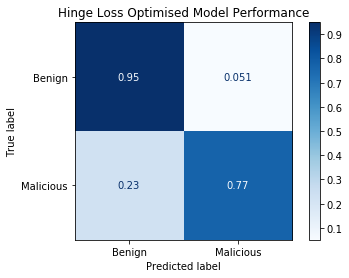

In [162]:
y_pred = hinge_loss_searchcv.predict(x_test)
print(f'TPR: {tpr(y_test, y_pred)}\nTNR: {tnr(y_test, y_pred)}\nFPR: {fpr(y_test, y_pred)}\nFNR: {fnr(y_test, y_pred)}')
print(f'Optimised SVC() Accuracy Score: {accuracy_score(y_test, y_pred)}')
print(f'Best params found: {hinge_loss_searchcv.best_params_}')

disp = plot_confusion_matrix(hinge_loss_searchcv.best_estimator_, x_test, y_test,
                                 display_labels=['Benign', 'Malicious'],
                                 cmap=plt.cm.Blues,
                                 normalize='true')
disp.ax_.set_title('Hinge Loss Optimised Model Performance')
plt.show()

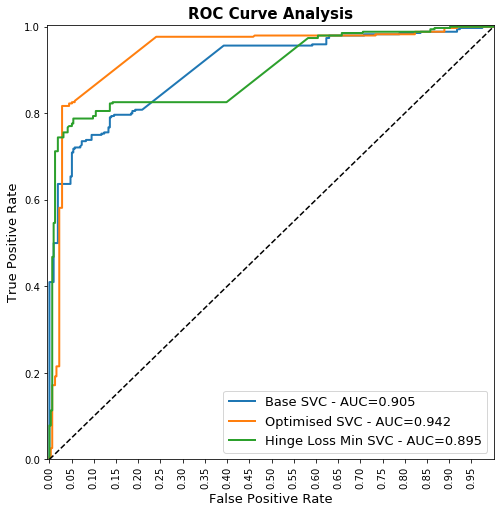

In [143]:
from sklearn.metrics import roc_curve, auc

y_scores_base = base_svc.decision_function(x_test)
y_scores_opt = searchcv.decision_function(x_test)
y_scores_hinge_loss = hinge_loss_searchcv.decision_function(x_test)

fpr_base, tpr_base, auc_thresholds_base = roc_curve(y_test, y_scores_base)
fpr_bayesian, tpr_bayesian, auc_thresholds = roc_curve(y_test, y_scores_opt)
fpr_hinge, tpr_hinge, auc_thresholds_base = roc_curve(y_test, y_scores_hinge_loss)

plt.figure(figsize=(8,8))
plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.plot(fpr_base, tpr_base, linewidth=2, label="Base {} - AUC={:.3f}".format(new_model.__class__.__name__, auc(fpr_base, tpr_base)))
plt.plot(fpr_bayesian, tpr_bayesian, linewidth=2, label="Optimised {} - AUC={:.3f}".format(searchcv.best_estimator_.__class__.__name__, auc(fpr_bayesian, tpr_bayesian)))
plt.plot(fpr_hinge, tpr_hinge, linewidth=2, label="Hinge Loss Min {} - AUC={:.3f}".format(hinge_loss_searchcv.best_estimator_.__class__.__name__, auc(fpr_hinge, tpr_hinge)))
plt.plot([0,1], [0,1], 'k--')
plt.axis([-0.005, 1, 0, 1.005])
plt.xticks(np.arange(0, 1, step=0.05), rotation=90)
plt.xlabel("False Positive Rate", fontsize=13)
plt.ylabel("True Positive Rate", fontsize=13)
plt.legend(prop={'size':13}, loc='best')

plt.show()


In [161]:
print('Hinge Loss Optimised SVC() BayesianSearchCV Metrics Results\n\n')
idx = 0
for _ in hinge_loss_searchcv.cv_results_['params']:
    print(f'===Iteration {idx+1}===')
    for metric in metrics:
        print(f'- {metric}: {hinge_loss_searchcv.cv_results_[metric][idx]}')
    idx+=1
    print('\n\n')

Hinge Loss Optimised SVC() BayesianSearchCV Metrics Results


===Iteration 1===
- mean_test_score: -0.9791044776119403
- mean_fit_time: 0.6048301219940185
- param_C: 0.0024906712592239
- param_gamma: 1.1586500161506312e-06
- param_kernel: poly
- param_degree: 8



===Iteration 2===
- mean_test_score: -0.9791043857277522
- mean_fit_time: 0.3456331729888916
- param_C: 453.46532293501156
- param_gamma: 4.563815188758282e-05
- param_kernel: poly
- param_degree: 3



===Iteration 3===
- mean_test_score: -0.9791032025517932
- mean_fit_time: 0.40923409461975097
- param_C: 0.001171181576626461
- param_gamma: 3.9806033524441374e-06
- param_kernel: rbf
- param_degree: 7



===Iteration 4===
- mean_test_score: -0.38774217931084376
- mean_fit_time: 0.2973851203918457
- param_C: 16003.673903517381
- param_gamma: 1.6598202016944635e-05
- param_kernel: rbf
- param_degree: 5



===Iteration 5===
- mean_test_score: -0.9791044720353318
- mean_fit_time: 0.46190409660339354
- param_C: 3121.9177407772527
-

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import KFold
from skopt import BayesSearchCV
from sklearn.model_selection import GridSearchCV

import scipy.sparse

X_train = scipy.sparse.load_npz(X_TRAIN_CSR_LOC)
Y_train = pd.read_csv(Y_TRAIN_LOC, header=None)[1]
X_test = scipy.sparse.load_npz(X_TEST_CSR_LOC)
Y_test = pd.read_csv(Y_TEST_LOC, header=None)[1]

base_knn = KNeighborsClassifier()

knn_scores = cross_validate(base_svc, X_train, Y_train, scoring=scoring, cv=cv, n_jobs=-1)
base_svc.fit(X_train, Y_train)

def get_avg_stats(stat):
    total = 0
    for item in stat:
        total += item
    
    avg = (total/stat.size)
    return avg

print("Base SVC() Model Average Performance Metrics\n\nTP: {}\nRate: {}\n\nTN: {}\nRate: {}\n\nFP: {}\nRate: {}\n\nFN: {}\nRate: {}\n".format(
    get_avg_stats(knn_scores["test_tp"]),
    get_avg_stats(knn_scores["test_tpr"]),
    get_avg_stats(knn_scores["test_tn"]),
    get_avg_stats(knn_scores["test_tnr"]),
    get_avg_stats(knn_scores["test_fp"]),
    get_avg_stats(knn_scores["test_fpr"]),
    get_avg_stats(knn_scores["test_fn"]),
    get_avg_stats(knn_scores["test_fnr"]),
))

base_knn.fit(X_train, Y_train)
knn_y_pred = base_knn.predict(X_test)
display(f'Base KNN Accuracy Score: {accuracy_score(Y_test, knn_y_pred)}')

# cv = KFold(n_splits=10, shuffle=True, random_state=1)

knn_search_space = {
    'leaf_size': list(range(1, 50)),
    'n_neighbors': list(range(1, 30)),
    'p': [1, 2]
}

knn_searchcv = BayesSearchCV(
    estimator=KNeighborsClassifier(),
    search_spaces = knn_search_space,
    cv=cv,
    verbose=5,
    n_jobs=-1
)

def on_step(optim_result):
    score = knn_searchcv.best_score_
    print(f'Best score: {score}')
    if score >= 0.98:
        print('Interrupting!')
        return True

    
import time
start_time = time.time()

knn_searchcv.fit(X_train, Y_train)
print("--- %s seconds ---" % (time.time() - start_time))

display(knn_searchcv.score(X_test, Y_test))
data_to_json(knn_searchcv.best_estimator_.__dict__, KNN_MODEL_LOC)

0.8545454545454545

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    3.1s remaining:    2.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.0s


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.0s


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.3s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished
/Users/chrismclearnon/miniconda3/envs/proj-env/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished
/Users/chrismclearnon/miniconda3/envs/proj-env/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished
/Users/chrismclearnon/miniconda3/envs/proj-env/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished
/Users/chrismclearnon/miniconda3/envs/proj-env/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished
/Users/chrismclearnon/miniconda3/envs/proj-env/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished
/Users/chrismclearnon/miniconda3/envs/proj-env/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished
/Users/chrismclearnon/miniconda3/envs/proj-env/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished
/Users/chrismclearnon/miniconda3/envs/proj-env/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished
/Users/chrismclearnon/miniconda3/envs/proj-env/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished
/Users/chrismclearnon/miniconda3/envs/proj-env/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished
/Users/chrismclearnon/miniconda3/envs/proj-env/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished
/Users/chrismclearnon/miniconda3/envs/proj-env/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished
/Users/chrismclearnon/miniconda3/envs/proj-env/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished
/Users/chrismclearnon/miniconda3/envs/proj-env/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished
/Users/chrismclearnon/miniconda3/envs/proj-env/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished
/Users/chrismclearnon/miniconda3/envs/proj-env/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished
/Users/chrismclearnon/miniconda3/envs/proj-env/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished
/Users/chrismclearnon/miniconda3/envs/proj-env/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.2s finished
/Users/chrismclearnon/miniconda3/envs/proj-env/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished
/Users/chrismclearnon/miniconda3/envs/proj-env/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished
/Users/chrismclearnon/miniconda3/envs/proj-env/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished
/Users/chrismclearnon/miniconda3/envs/proj-env/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished
/Users/chrismclearnon/miniconda3/envs/proj-env/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished
/Users/chrismclearnon/miniconda3/envs/proj-env/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished
/Users/chrismclearnon/miniconda3/envs/proj-env/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished
/Users/chrismclearnon/miniconda3/envs/proj-env/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished


--- 137.81989407539368 seconds ---


0.8924242424242425

'{\n    "n_neighbors": 1,\n    "radius": null,\n    "algorithm": "auto",\n    "leaf_size": 15,\n    "metric": "minkowski",\n    "metric_params": null,\n    "p": 1,\n    "n_jobs": null,\n    "weights": "uniform",\n    "outputs_2d_": false,\n    "classes_": {\n        "py/numpy.ndarray": {\n            "values": [\n                0,\n                1\n            ],\n            "dtype": "int64"\n        }\n    },\n    "_y": {\n        "py/numpy.ndarray": {\n            "values": [\n                0,\n                1,\n                0,\n                1,\n                1,\n                1,\n                0,\n                1,\n                0,\n                1,\n                1,\n                1,\n                0,\n                1,\n                1,\n                0,\n                0,\n                0,\n                1,\n                1,\n                0,\n                0,\n                1,\n                0,\n                1,\n            

In [165]:
knn_search_space = {
    'leaf_size': list(range(1, 50)),
    'n_neighbors': list(range(1, 30)),
    'p': [1, 2]
}

knn_searchcv = BayesSearchCV(
    estimator=KNeighborsClassifier(),
    search_spaces = knn_search_space,
    cv=cv,
    verbose=5,
    n_jobs=-1
)

def on_step(optim_result):
    score = knn_searchcv.best_score_
    print(f'Best score: {score}')
    if score >= 0.98:
        print('Interrupting!')
        return True

    
import time
start_time = time.time()

knn_searchcv.fit(X_train, Y_train, callback=on_step)
print("--- %s seconds ---" % (time.time() - start_time))

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Best score: 0.8932835820895523
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Best score: 0.8932835820895523
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Best score: 0.8932835820895523
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.0s


Best score: 0.8932835820895523
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Best score: 0.8932835820895523
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Best score: 0.8932835820895523
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished


Best score: 0.8932835820895523
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Best score: 0.8932835820895523
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.2s finished


Best score: 0.8932835820895523
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished


Best score: 0.8932835820895523


/Users/chrismclearnon/miniconda3/envs/proj-env/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished


Best score: 0.8932835820895523


/Users/chrismclearnon/miniconda3/envs/proj-env/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished


Best score: 0.8932835820895523
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished


Best score: 0.8932835820895523
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished


Best score: 0.8932835820895523


/Users/chrismclearnon/miniconda3/envs/proj-env/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished


Best score: 0.8932835820895523


/Users/chrismclearnon/miniconda3/envs/proj-env/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished


Best score: 0.8932835820895523


/Users/chrismclearnon/miniconda3/envs/proj-env/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished


Best score: 0.8932835820895523


/Users/chrismclearnon/miniconda3/envs/proj-env/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished


Best score: 0.8932835820895523


/Users/chrismclearnon/miniconda3/envs/proj-env/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished


Best score: 0.8932835820895523


/Users/chrismclearnon/miniconda3/envs/proj-env/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished


Best score: 0.8932835820895523
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished


Best score: 0.8992537313432836
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished


Best score: 0.8992537313432836


/Users/chrismclearnon/miniconda3/envs/proj-env/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished


Best score: 0.8992537313432836


/Users/chrismclearnon/miniconda3/envs/proj-env/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished


Best score: 0.8992537313432836


/Users/chrismclearnon/miniconda3/envs/proj-env/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished


Best score: 0.8992537313432836
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished


Best score: 0.8992537313432836
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished


Best score: 0.8992537313432836


/Users/chrismclearnon/miniconda3/envs/proj-env/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished


Best score: 0.8992537313432836


/Users/chrismclearnon/miniconda3/envs/proj-env/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished


Best score: 0.8992537313432836


/Users/chrismclearnon/miniconda3/envs/proj-env/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished


Best score: 0.8992537313432836


/Users/chrismclearnon/miniconda3/envs/proj-env/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished


Best score: 0.8992537313432836
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished


Best score: 0.8992537313432836


/Users/chrismclearnon/miniconda3/envs/proj-env/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished


Best score: 0.8992537313432836


/Users/chrismclearnon/miniconda3/envs/proj-env/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished


Best score: 0.8992537313432836


/Users/chrismclearnon/miniconda3/envs/proj-env/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished


Best score: 0.8992537313432836


/Users/chrismclearnon/miniconda3/envs/proj-env/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished


Best score: 0.8992537313432836


/Users/chrismclearnon/miniconda3/envs/proj-env/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished


Best score: 0.8992537313432836


/Users/chrismclearnon/miniconda3/envs/proj-env/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished


Best score: 0.8992537313432836


/Users/chrismclearnon/miniconda3/envs/proj-env/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.3s finished


Best score: 0.8992537313432836


/Users/chrismclearnon/miniconda3/envs/proj-env/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished


Best score: 0.8992537313432836


/Users/chrismclearnon/miniconda3/envs/proj-env/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished


Best score: 0.8992537313432836


/Users/chrismclearnon/miniconda3/envs/proj-env/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished


Best score: 0.8992537313432836


/Users/chrismclearnon/miniconda3/envs/proj-env/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished


Best score: 0.8992537313432836
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished


Best score: 0.8992537313432836


/Users/chrismclearnon/miniconda3/envs/proj-env/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished


Best score: 0.8992537313432836


/Users/chrismclearnon/miniconda3/envs/proj-env/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished


Best score: 0.8992537313432836


/Users/chrismclearnon/miniconda3/envs/proj-env/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished


Best score: 0.8992537313432836


/Users/chrismclearnon/miniconda3/envs/proj-env/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished


Best score: 0.8992537313432836


/Users/chrismclearnon/miniconda3/envs/proj-env/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished


Best score: 0.8992537313432836


/Users/chrismclearnon/miniconda3/envs/proj-env/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished


Best score: 0.8992537313432836
--- 154.37158298492432 seconds ---


In [ ]:
print(f'TPR: {tpr(y_test, y_pred)}\nTNR: {tnr(y_test, y_pred)}\nFPR: {fpr(y_test, y_pred)}\nFNR: {fnr(y_test, y_pred)}')
print(f'Optimised SVC() Accuracy Score: {accuracy_score(y_test, y_pred)}')
print(f'Best params found: {searchcv.best_params_}')

data_to_json(knn_searchcv.best_estimator_.__dict__, KNN_MODEL_LOC)

In [155]:
Y_pred_decision1 = searchcv.decision_function(X_test)
display(f'Standard Hinge Loss: {hinge_loss(Y_test, Y_pred_decision)}')
display(f'Scorer Function Hinge Loss: {scorer(searchcv.best_estimator_, X_test, Y_test)}')

'Standard Hinge Loss: 0.3735628831531258'

'Scorer Function Hinge Loss: -0.33419750050496044'